# Met Data Processing
Final/Clean Version of MET_Data_Analysis_Raw.ipynb
by Bharat Sharma <br>
sharmabd@ornl.gov <br>
Site: US-DUKE



In [1]:
# importing libraries
import xarray as xr
import glob
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Files
- **ELM-DUKE** : has the nc files that we use to run the current version of ELM-FATES <br>
- **[FACEMDS_Walker2018](https://data.ess-dive.lbl.gov/view/ess-dive-7807cf86f1dd42a-20181127T173047368940)** : Processed Data (My focus: DUKE) <br>
- **[DukeFACE_Oren2022](https://data.ess-dive.lbl.gov/view/doi:10.15485/1895465)**: Updated DUKE met Data


In [2]:
# paths

paths = {}
paths ["ELM-DUKE"] = "/Users/ud4/Documents/FACEMDS/MET_Data_Processing/ELM_Data/data/atm/datm7/CLM1PT_data/1x1pt_US-DUK/"
paths ["FACEMDS_Walker2018"] = "/Users/ud4/Documents/FACEMDS/MET_Data_Processing/Walker_2018_FATES_MDS/data/"
paths ["DukeFACE_Oren2022"] = "/Users/ud4/Documents/FACEMDS/MET_Data_Processing/Oren_2022_DUKE_Met/data/"
paths ["Raleigh_Airport_Met"] = "/Users/ud4/Documents/FACEMDS/MET_Data_Processing/"
paths ["Save_Processed"] = "/Users/ud4/Documents/FACEMDS/MET_Data_Processing/Oren_2022_Met_Data_processed/"

## ELM Duke Data

In [3]:
key = "ELM-DUKE"
ds_elm_all= xr.open_mfdataset(glob.glob(f"{paths[key]}*.nc"))

In [4]:
#cftime to datetime 

def cftime_to_dtime (cftime_object):
    # Convert cftime.DatetimeNoLeap to datetime
    datetime_object = datetime(
        year=cftime_object.year,
        month=cftime_object.month,
        day=cftime_object.day,
        hour=cftime_object.hour,
        minute=cftime_object.minute,
        second=cftime_object.second,
        microsecond=cftime_object.microsecond,
    )
    return datetime_object

time_objects = [cftime_to_dtime (t) for t in ds_elm_all.time.values]
print (time_objects)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



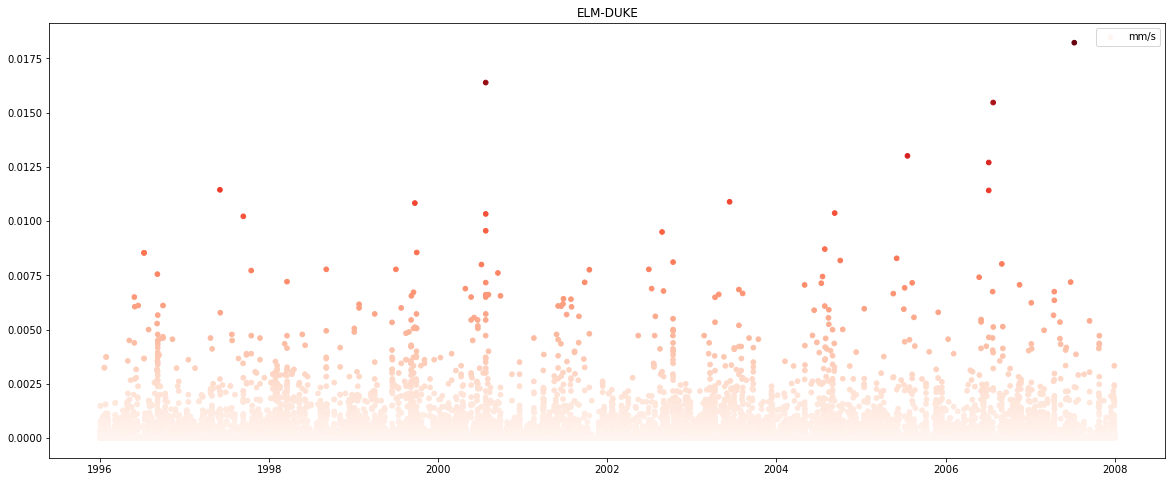

In [5]:
fig1 = plt.figure(figsize=(20,8))
plt.scatter(x= time_objects, y=ds_elm_all.PRECTmms, 
            c=ds_elm_all.PRECTmms, cmap='Reds', 
            s=22, marker = 'o',label = ds_elm_all.PRECTmms.units,
           )
plt.title(f"{key}")
plt.legend()

## Investigating FACEMDS_Walker2018

In [6]:
key = "FACEMDS_Walker2018"
ds_Walker_h= xr.open_dataset(f"{paths[key]}DUKE_forcing_h.nc", decode_times=False)

from datetime import datetime, timedelta

def seconds_to_datetime(seconds, reference_date):
    return reference_date + timedelta(seconds=seconds)

reference_date= datetime(1996, 1, 1, 0 , 0)

list_seconds = ds_Walker_h.TIME[...].values
list_seconds= np.asarray(list_seconds, dtype = float)
resulting_datetime = [seconds_to_datetime(seconds,reference_date) for seconds in list_seconds]


/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


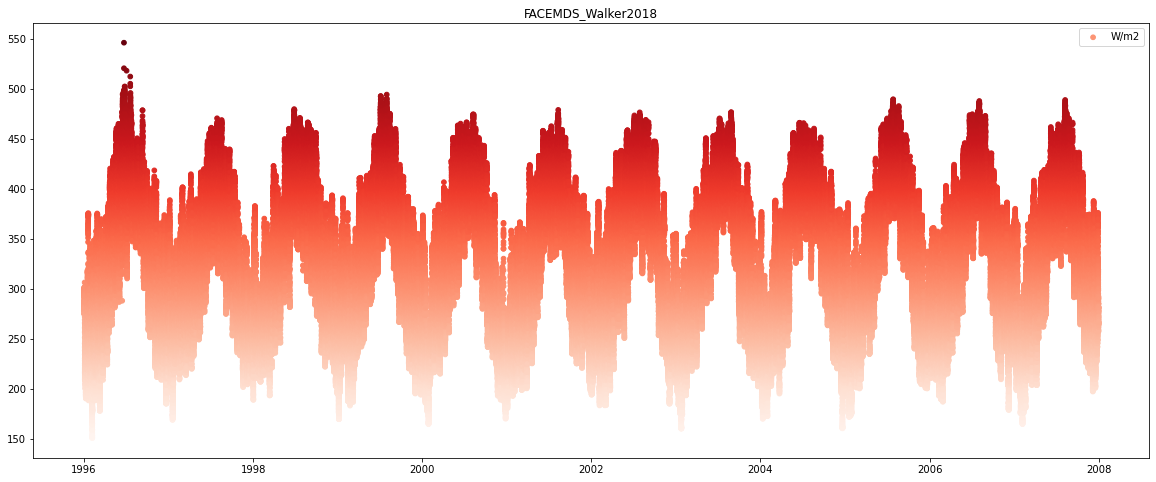

In [7]:
fig2 = plt.figure(figsize=(20,8))
plt.scatter(x= resulting_datetime, y=ds_Walker_h['LWdown'], 
            c=ds_Walker_h['LWdown'], cmap='Reds', 
            s=22, marker = 'o',label = ds_Walker_h['LWdown'].units
           )
plt.title(f"{key}")
plt.legend()

### FACEMDS_Walker CSV files

In [8]:
key = "FACEMDS_Walker2018"

#### Reading Hourly files

In [9]:
df_FACEMDS = {}
df_FACEMDS ['h'] = pd.read_csv(glob.glob(f"{paths[key]}DUKE*_h.txt")[0], delimiter= '\t')
print(len(df_FACEMDS ['h'] .columns))
df_FACEMDS ['h'] .columns

30


/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['YEAR', 'DTIME', 'DOY', 'HRMIN', 'Rainf', 'Rainf_f ', 'Tair', 'Tair_f',
       'RH', 'RH_f', 'VPD', 'VPD_f', 'Qair', 'Qair_f', 'Wind', 'Wind_f',
       'SWdown', 'SWdown_f', 'PAR', 'PAR_f', 'LWdown', 'LWdown_f', 'PSurf',
       'PSurf_f', 'aCO2', 'eCO2', 'aO3', 'eO3', 'Ndep', 'SolarElevation'],
      dtype='object')

## Oren New Met Data

In [10]:
# Dictionary that will contain the dataframes of all the variables from Oren New Met Data
dict_dfs_common = {}

In [11]:
# Specify the file path
DuplicateDataFilename = 'DuplicateDukeData.txt'

# This file path is to document the duplicate Data in Duke Data

### AT : Tair
Oren Data has 3 dirs for AT for different plots, time periods, and sensors. <br>
I intend to use `*_gl.csv` files; i believe these are gap filled. <br>
I will save the mean of the plots for FACEMDS <br>
The common sensor data will be used among all the files.

In [12]:
key = "DukeFACE_Oren2022"
var_key = "AT"
face_var_key = "Tair"

plots_cols = ['R1uat', 'R2uat', 'R3uat', 'R4uat','R5uat', 'R6uat', 'R7uat', 'R8uat']

In [13]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Define a custom sorting key function to extract the year from the file path
def extract_year(filepath):
    return int(filepath.split(f'{var_key}')[-1][:4]) # Year

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)


In [14]:
# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf




In [15]:
file = sorted_filepaths[0]
df_tmp = pd.read_csv(file)

In [16]:
df_tmp

Year      JDT  DOY  Time  R1uat  R2uat  R3uat  R4uat  R5uat  R6uat  \
0      1997  2682.71  125  1730   21.5   21.5   21.5   21.5   21.5   21.4   
1      1997  2682.73  125  1800   20.4   20.4   20.4   20.4   20.4   20.4   
2      1997  2682.75  125  1830   18.9   18.9   18.9   18.9   18.9   18.8   
3      1997  2682.77  125  1900   17.9   17.9   17.9   17.9   17.9   18.1   
4      1997  2682.79  125  1930   16.6   16.6   16.6   16.6   16.6   16.5   
...     ...      ...  ...   ...    ...    ...    ...    ...    ...    ...   
11529  1997  2922.90  365  2200   -2.0   -0.7   -1.6   -2.0   -1.9   -2.2   
11530  1997  2922.92  365  2230   -2.3   -0.9   -1.9   -2.3   -2.1   -2.5   
11531  1997  2922.94  365  2300   -2.4   -1.1   -2.1   -2.4   -2.3   -2.6   
11532  1997  2922.96  365  2330   -2.6   -1.2   -2.2   -2.6   -2.4   -2.7   
11533  1997  2922.98  365  2400   -3.0   -1.6   -2.6   -2.9   -2.7   -3.1   

       R7uat  R8uat  
0       21.5   21.6  
1       20.4   20.5  
2       18.9   18.9  
3       17.6   18.1  
4       16.9   16.5  
...      ...    ...  
11529   -2.1   -1.8  
11530   -2.4   -2.1  
11531   -2.5   -2.2  
11532   -2.6   -2.3  
11533   -3.0   -2.7  

[11534 rows x 12 columns]

### Precip : Rainf
units: mm

In [17]:
key = "DukeFACE_Oren2022"
var_key = "Precip"
face_var_key = "Rainf"

plots_cols = ['FACE.PO']

In [18]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### RH : RH
Relative Humidity

In [19]:
key = "DukeFACE_Oren2022"
var_key = "RH"
face_var_key = "RH"
plots_cols = ['R1urh', 'R2urh', 'R3urh', 'R4urh','R5urh', 'R6urh', 'R7urh', 'R8urh']

In [20]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### SM:SM 
(not in existing WalkerFACEMDS Data)<br>
Soil moisture integrates measurements from 0 to 30cm depth 

In [21]:
key = "DukeFACE_Oren2022"
var_key = "SM"
face_var_key = "SM"

plots_cols = ['R1tdr', 'R2tdr', 'R3tdr', 'R4tdr','R5tdr', 'R6tdr', 'R7tdr', 'R8tdr']

In [22]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### SWP: SWP 
not in existing Walker 2018 <br>
(Soil water potential) <br>
from 2007 to 2012

In [23]:
key = "DukeFACE_Oren2022"
var_key = "SWP"
face_var_key = "SWP"
plots_cols = ['R1swp', 'R2swp', 'R3swp', 'R4swp','R5swp', 'R6swp']

In [24]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### SVP: SVP

Saturated Vapor Pressure; Not in Walker 2018<br>
units kPa   

In [25]:
key = "DukeFACE_Oren2022"
var_key = "SVP"
face_var_key = "SVP"
plots_cols = ['R1usvp', 'R2usvp', 'R3usvp', 'R4usvp','R5usvp', 'R6usvp', 'R7usvp', 'R8usvp']

In [26]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### VPD: VPD
Vapor pressure deficit <br>
Units kPa <br>

In [27]:
key = "DukeFACE_Oren2022"
var_key = "VPD"
face_var_key = "VPD"
plots_cols = ['R1uvpd', 'R2uvpd', 'R3uvpd', 'R4uvpd','R5uvpd', 'R6uvpd', 'R7uvpd', 'R8uvpd']

In [28]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### SLT: SLT

Walker 2018 does not have this data <br>
soil temperature from plots 1-6, one sensor per plot at 15 cm depth, measured in Degree Celsius. <br>
I will be averaging over plots 2-6 because 1 was upgraded over time and 15 cm depth was not avaiable later 

In [29]:
key = "DukeFACE_Oren2022"
var_key = "SLT"
face_var_key = "SLT"
plots_cols = ['R2slt', 'R3slt', 'R4slt','R5slt', 'R6slt']

In [30]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf


### PAR: PAR

The data from 2008-12 was averaged to get PAN and Rn <br>
PAR - Photosynthetically active radiation, umol/m^2\*s <br>
PAR had values from only one plot for 1997-2007 and from two plots for 2008-2012, which were averaged <br> 

In [31]:
key = "DukeFACE_Oren2022"
var_key = "PAR"
face_var_key = "PAR"
plots_cols = ['PAR']

exp_filename = "Rad" # Exception in the filename

In [32]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{exp_filename}*/*_gf.csv"))

# Define a custom sorting key function to extract the year from the file path
def extract_year(filepath):
    return int(filepath.split(f'{exp_filename}')[-1][:4]) # Year
    
# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf


### Rn: Rn 

Not in Walker 2018 <br>
The data from 2008-12 was averaged to get PAN and Rn <br>
Rn  - Net radiation. Q7 sensor before 2004, CNR1 thereafter, W/m^2  <br>
Rn had values from only one plot for 1997-2007 and from two plots for 2008-2012, which were averaged <br> 

In [33]:
key = "DukeFACE_Oren2022"
var_key = "Rn"
face_var_key = "Rn"
plots_cols = ['Rn']

exp_filename = "Rad" # Exception in the filename

In [34]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{exp_filename}*/*_gf.csv"))

# Define a custom sorting key function to extract the year from the file path
def extract_year(filepath):
    return int(filepath.split(f'{exp_filename}')[-1][:4]) # Year
    
# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf


### PAR: PAR 
Saving the existing PAR in a new variable 'PAR_ori'. <br>
Correcting existing values of PAR that reduce over time because of the degrading sensor <br>


In [35]:
dict_dfs_common['PAR_ori'] = dict_dfs_common['PAR']
dict_dfs_common['PAR_ori']['PAR_ori'] = dict_dfs_common['PAR_ori']['PAR']
dict_dfs_common['PAR_ori'] = dict_dfs_common['PAR_ori'].drop(['PAR'], axis=1)
dict_dfs_common['PAR_ori']

Year      JDT  DOY  Time  PAR_ori
0      1997  2558.00    1    30      0.0
1      1997  2558.02    1   100      0.0
2      1997  2558.04    1   130      0.0
3      1997  2558.06    1   200      0.0
4      1997  2558.08    1   230      0.0
...     ...      ...  ...   ...      ...
17563  2012  8401.90  366  2200      0.0
17564  2012  8401.92  366  2230      0.0
17565  2012  8401.94  366  2300      0.0
17566  2012  8401.96  366  2330      0.0
17567  2012  8401.98  366  2400      0.0

[280512 rows x 5 columns]

In [36]:
import seaborn as sns
from PIL import Image, ImageDraw

iter = 16

palette = list(reversed(sns.color_palette("Spectral_r", iter).as_hex()))
print(palette)

width_px=1000
new = Image.new(mode="RGB", size=(width_px,120))

for i in range(iter):

    newt = Image.new(mode="RGB", size=(width_px//iter,100), color=palette[i])
    new.paste(newt, (i*width_px//iter,10))

['#be254a', '#da464d', '#ed6246', '#f7844e', '#fcaa5f', '#fec877', '#fee491', '#fff6b0', '#f8fcb4', '#e9f69d', '#caea9e', '#a7dba4', '#7ecca5', '#5ab4ab', '#3b92b9', '#4471b2']


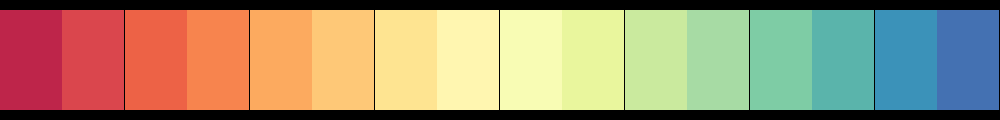

In [37]:
new

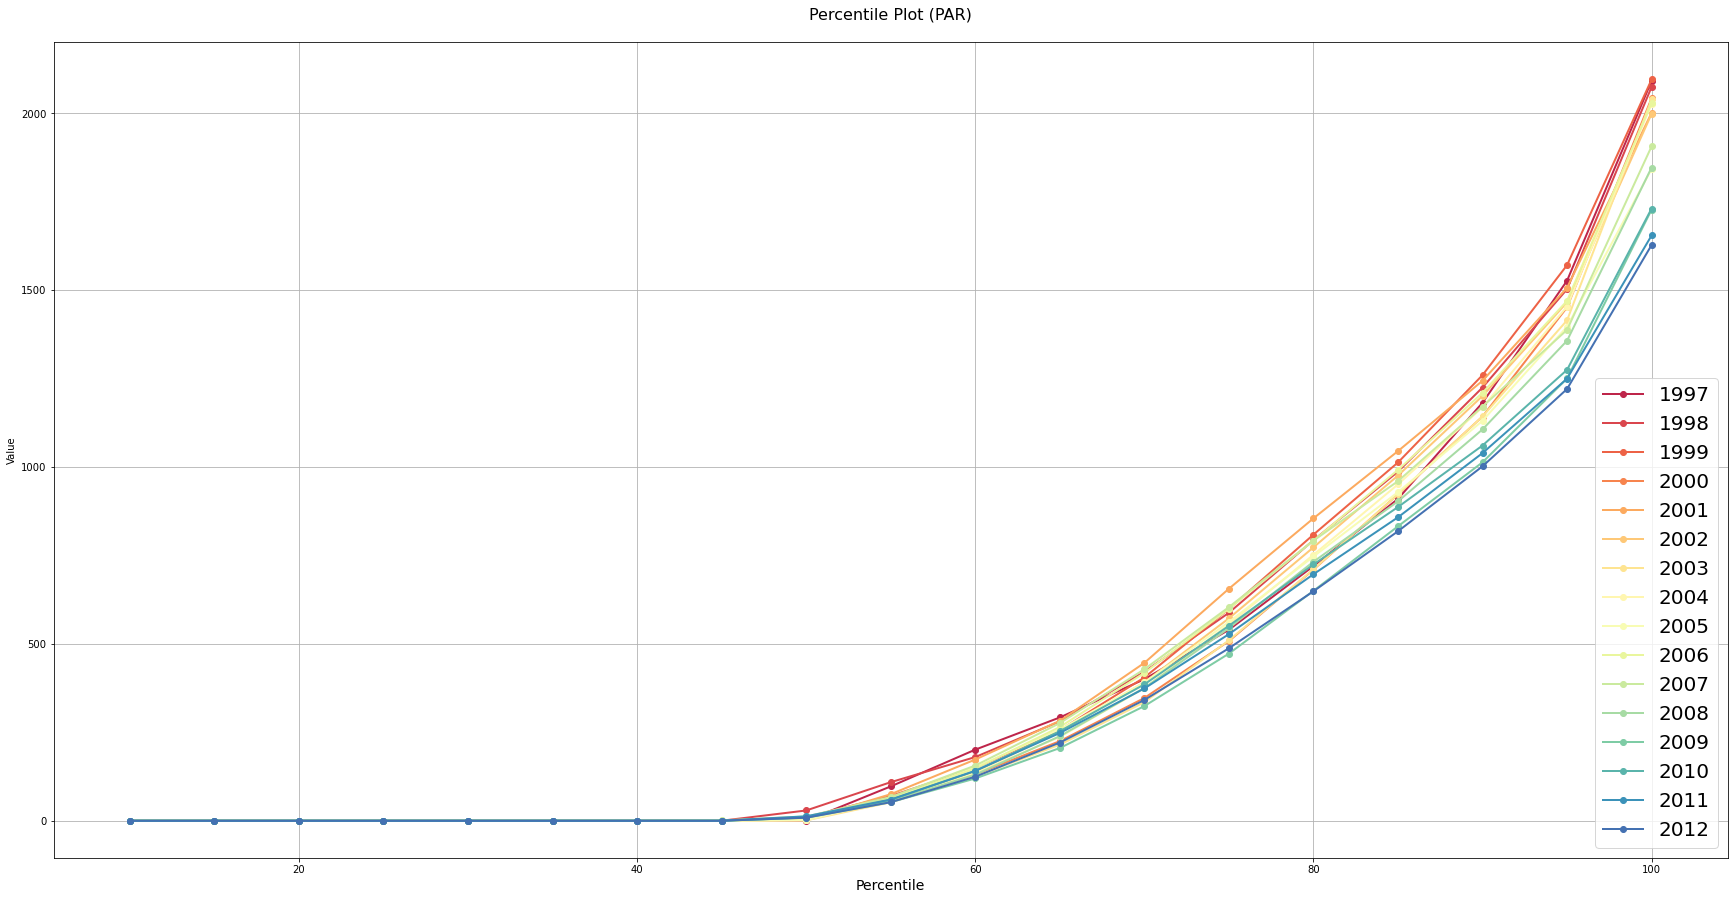

In [38]:
plt.figure(figsize=(30, 15))

color_list = ['#be254a', '#da464d', '#ed6246', '#f7844e', '#fcaa5f', '#fec877', '#fee491', '#fff6b0', '#f8fcb4', '#e9f69d', '#caea9e', '#a7dba4', '#7ecca5', '#5ab4ab', '#3b92b9', '#4471b2']
per_95 = []
per_90 = []
per_60 = []
i=0
for lbl,gr in dict_dfs_common['PAR'].groupby(['Year']):
    # Calculate percentiles (10th, 20th, 30th, ..., 100th)
    percentiles = np.arange(10, 101, 5)
    percentile_values = np.percentile(gr['PAR'], percentiles)
    per_95.append((int(lbl), percentile_values[-2])) 
    per_90.append((int(lbl), percentile_values[-3])) 
    per_60.append((int(lbl), percentile_values[10]))
    # Plot percentiles
    plt.plot(percentiles[:], percentile_values[:], marker='o', linestyle='-', c = color_list[i], lw=2,label = f'{int(lbl)}')
    plt.title('Percentile Plot (PAR)\n', fontsize=16)
    plt.xlabel('Percentile',fontsize=14)
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc=4, fontsize=20)
    i=i+1
    #plt.show()

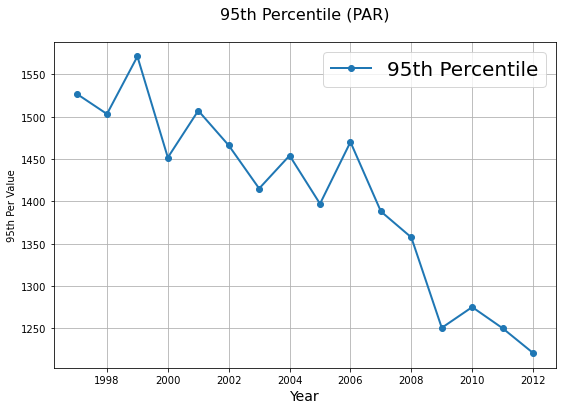

In [39]:
# Plot percentiles
if True:
    plt.figure(figsize=(9, 6))
    plt.plot(np.array(per_95)[:,0], np.array(per_95)[:,1], marker='o', linestyle='-',  lw=2,label = f'95th Percentile')
    plt.title('95th Percentile (PAR)\n', fontsize=16)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('95th Per Value')
    plt.grid(True)
    plt.legend(loc=1, fontsize=20)

In [40]:
# Normalizing based on the 95th percent value
# Assuming that the sensor was good in the first 3 years
# Taking the average for first 3 years.
df_par_per = pd.DataFrame(data= np.array(per_95)[:,1], columns=['PAR_95p'])
df_par_per.index = np.asarray(np.array(per_95)[:,0], dtype=int)
df_par_per.index.name = 'Year'
base_95th = df_par_per.iloc[0:3].mean()

# Factor Reduction in amplitude
df_par_div_factor = df_par_per/base_95th

df_par_div_factor.columns = ['PAR_divisible_factor']
# we need to divide the original data with the factor corresponding the year of above array.


In [41]:
# Merge the original DataFrame with the factors DataFrame based on the 'Year' column
merged_df = dict_dfs_common['PAR'].merge(df_par_div_factor, on='Year', how='left')

# Calculate the modified 'PAR' column by dividing 'PAR' with 'PAR_95p'
merged_df['Modified_PAR'] = merged_df['PAR'] / merged_df['PAR_divisible_factor']


In [42]:
# Replacing the original PAR with new PAR values
merged_df['PAR'] = merged_df['Modified_PAR']
merged_df = merged_df.drop(['Modified_PAR', 'PAR_divisible_factor'], axis=1)
dict_dfs_common['PAR'] = merged_df


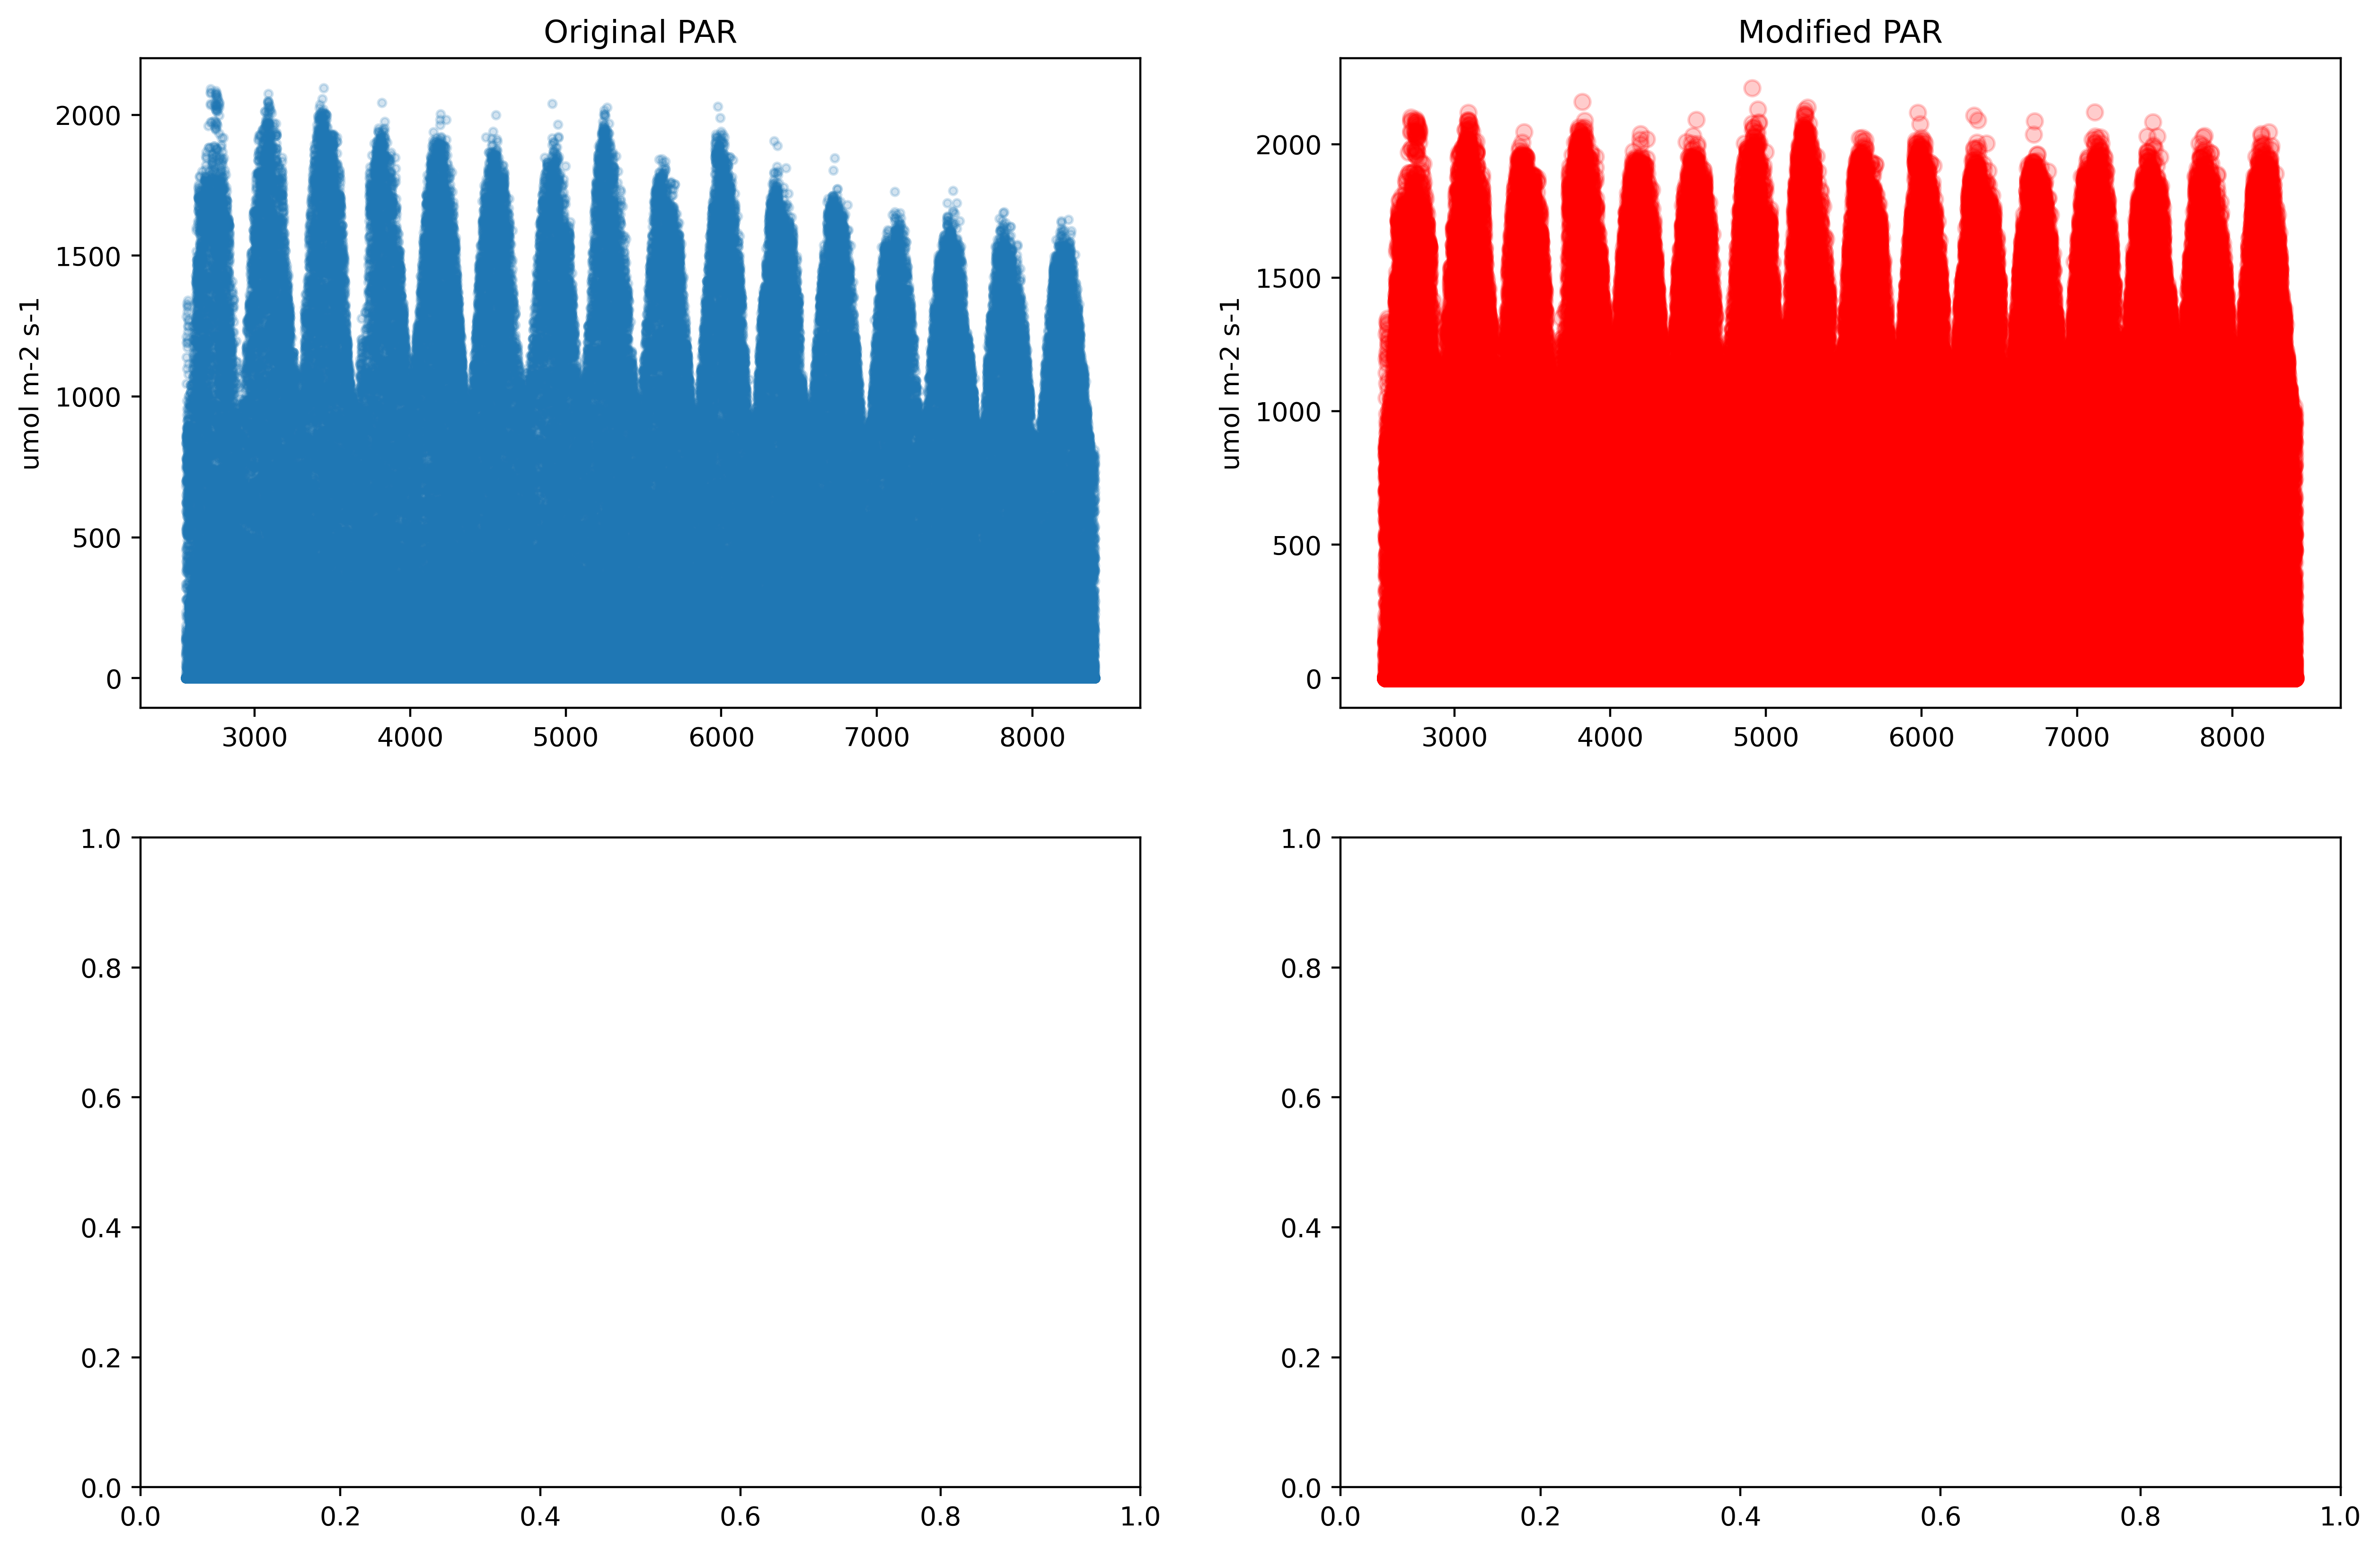

In [43]:


fig, axs = plt.subplots(2,2 , figsize=(15,10), dpi=400)


# 1
idx_ax = (0,0)
#var_plot = "Rainf"
#factor_add = 0
#factor_multiple = 1 # 1/(60*30) # From per day to per second for 48 timesteps in a day i.e. 24*60*60/48
axs[idx_ax].scatter(dict_dfs_common['PAR_ori']['JDT'], dict_dfs_common['PAR_ori']['PAR_ori'], marker=".", label = f"PAR_Ori",alpha=.2)
axs[idx_ax].set_ylabel (f"umol m-2 s-1")
#axs[idx_ax].set_ylim (0,.025)
axs[idx_ax].title.set_text("Original PAR")
#axs[idx_ax].grid(b=True, which='major', axis='both', linestyle='--', color='gray', linewidth=0.5)
idx_axr = (0,1)
axs[idx_axr].scatter(merged_df['JDT'], merged_df['PAR'], marker="o", color = 'r', label = f"PAR_Modified", alpha=.2)
axs[idx_axr].set_ylabel (f"umol m-2 s-1")
#axs[idx_axr].grid(b=True, which='major', axis='both', linestyle='--', color='gray', linewidth=0.5)
axs[idx_axr].title.set_text("Modified PAR")
#axs[idx_axr].set_ylim (0,.025)
#plt.legend()

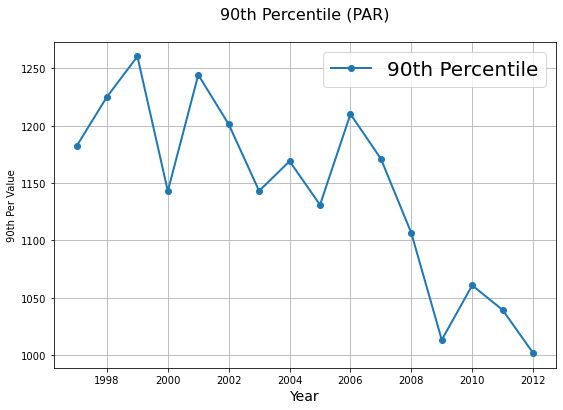

In [44]:
# Plot percentiles (Other options)
if True:
    plt.figure(figsize=(9, 6))
    plt.plot(np.array(per_90)[:,0], np.array(per_90)[:,1], marker='o', linestyle='-',  lw=2,label = f'90th Percentile')
    plt.title('90th Percentile (PAR)\n', fontsize=16)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('90th Per Value')
    plt.grid(True)
    plt.legend(loc=1, fontsize=20)

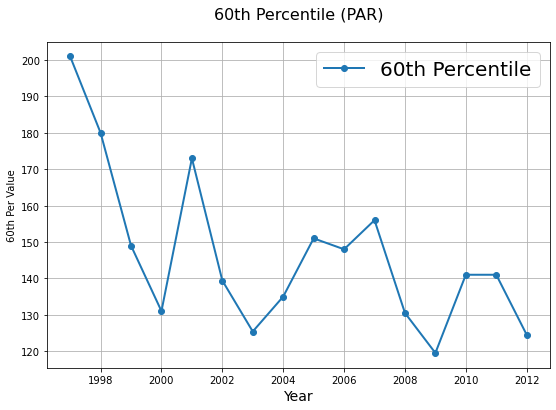

In [45]:
# Plot percentiles
if True:
    plt.figure(figsize=(9, 6))
    plt.plot(np.array(per_60)[:,0], np.array(per_60)[:,1], marker='o', linestyle='-',  lw=2,label = f'60th Percentile')
    plt.title('60th Percentile (PAR)\n', fontsize=16)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('60th Per Value')
    plt.grid(True)
    plt.legend(loc=1, fontsize=20)

### SWdown: SWdown 

Calculating it from PAR using the following function: <br>
Using the corrected par (umolm-2s-1) we calculate SWDown in (W/m2) <br>

In [46]:
def PAR2SWdown (data, out_units='umolm-2s-1'):
    """
    by BS
    
    input units: umolm-2s-1
    -----------------------
    
    Returns:
    --------
    PAR in desired out_units.
    
    Source: https://www.researchgate.net/post/Can-I-convert-PAR-photo-active-radiation-value-of-micro-mole-M2-S-to-Solar-radiation-in-Watt-m2/59ca6422217e201e2b23415f/citation/download
    It says PAR is 45% of total Solar radiation. However, most models use a factor of 0.5 or 50%. We will go with 0.5. 
    And 1 W/m2 ≈ 4.6 μmole/m2/s 
    
    """
    if out_units == 'umolm-2s-1':
        conversion_factor = 2 # (1/0.5)
    if out_units == 'W/m2':
        conversion_factor = 2/4.6 # (1/0.5/4.6)
        
    return data*conversion_factor
    

### LWDown

Calculating it from Tair and VPD using the following function: <br>
Based on https://github.com/fluxnet/ONEFlux/blob/9201beb15e6eca57bd6fd23a16cb5e46d4e2de7a/oneflux_steps/qc_auto/src/main.c#L2851-L2882 <br>
Use the function LWDown_oneflux to get LWDown in W/m2  <br>


#### LWDown Method 1 : Bai 

In [47]:
# Method 1
import math
def sat_vap(temp):
    # temp should have a unit of Deg C and svp will have a unit of kPa
    exponent = (17.502 * temp) / (240.97 + temp)
    svp = (0.61121 * math.exp(exponent))
    return svp

def lw_bai(svp,temp,rh):
    # temp should be K
    """
    This formula fails when the Temperature is < 0C or < 273.15K. It generates Complex numbers as solutions
    """
    temp = temp+273.15
    try:
        lw_bai = 1.31 * (svp*(temp - 273.15) * rh / temp / 10.0) ** (1.0 / 7.0) * 5.67 * (temp / 100.0) ** 4.0
    except:
        lw_bai = -6999.0
    
    return round(lw_bai)

#### LWDown Method 2 : Ni An 2017 

In [48]:

# Method 2
# Ta in C; RH in %, es is SVP in kPa at Ta
import math
def sat_vap_NiAn(temp):
    # temp should have a unit of Deg C and svp will have a unit of kPa
    exponent = (17.269 * temp) / (273.1 + temp)
    svp = (0.6107 * math.exp(exponent))
    return svp

def lw_2 (Ta, RH): 
    #paper Ni An 2017
    # https://www.sciencedirect.com/science/article/pii/S1674775516300944#sec2
    es = sat_vap_NiAn(Ta)
    #print (es)
    ea = RH*es/100
    epsa = 0.7 + 5.95*10**(-4)*ea* math.exp(1500/(Ta+273.1))
    sigma = 5.67 * 10**(-8) # W/(m2 K4)
    Ts= Ta+273.15
    lw = epsa *sigma *(Ts**4)
    return lw


#### LWDown Method 3 : OneFlux (Using)

In [49]:
#Method 3
def LWDown_oneflux (Ta, vpd): 
    """
    The formula is similar to the one used in OneFlux code
    Ta in C
    VPD in kPa
    
    Based on https://github.com/fluxnet/ONEFlux/blob/9201beb15e6eca57bd6fd23a16cb5e46d4e2de7a/oneflux_steps/qc_auto/src/main.c#L2851-L2882
    
    e.g. 
    df_temp['LWDown'] = df_temp.apply(lambda row: lw_3(row['Tair'], row['VPD']), axis=1)
    where df_temp is a pandas dataframe with columns of Tair in C and VPD in kPa.
    """
    
    
    T0 = 273.15
    Tstroke = 36
    A = 17.27
    ESTAR = 611
    Ts= Ta+T0
    
    esat = ESTAR * math.exp(A*((Ta/(Ts-Tstroke)))) 
                            
    vp = esat - (vpd * 100)
    if vp <0.0:
        vp = 3.3546e-004
    epsa = 0.64 * math.pow(vp/Ts,0.14285714) # ...
    sigma = 5.669e-8 # W/(m2 K4) #..
     #..
    lw = epsa *sigma *(Ts**4) #..
    return lw

In [50]:
df_temp = dict_dfs_common['Tair'].copy(deep=True)

# Apply the sat_vap function to create a new column 'Sat_Vap' in the DataFrame
df_temp['SVP'] = df_temp['Tair'].apply(lambda x: sat_vap(x))

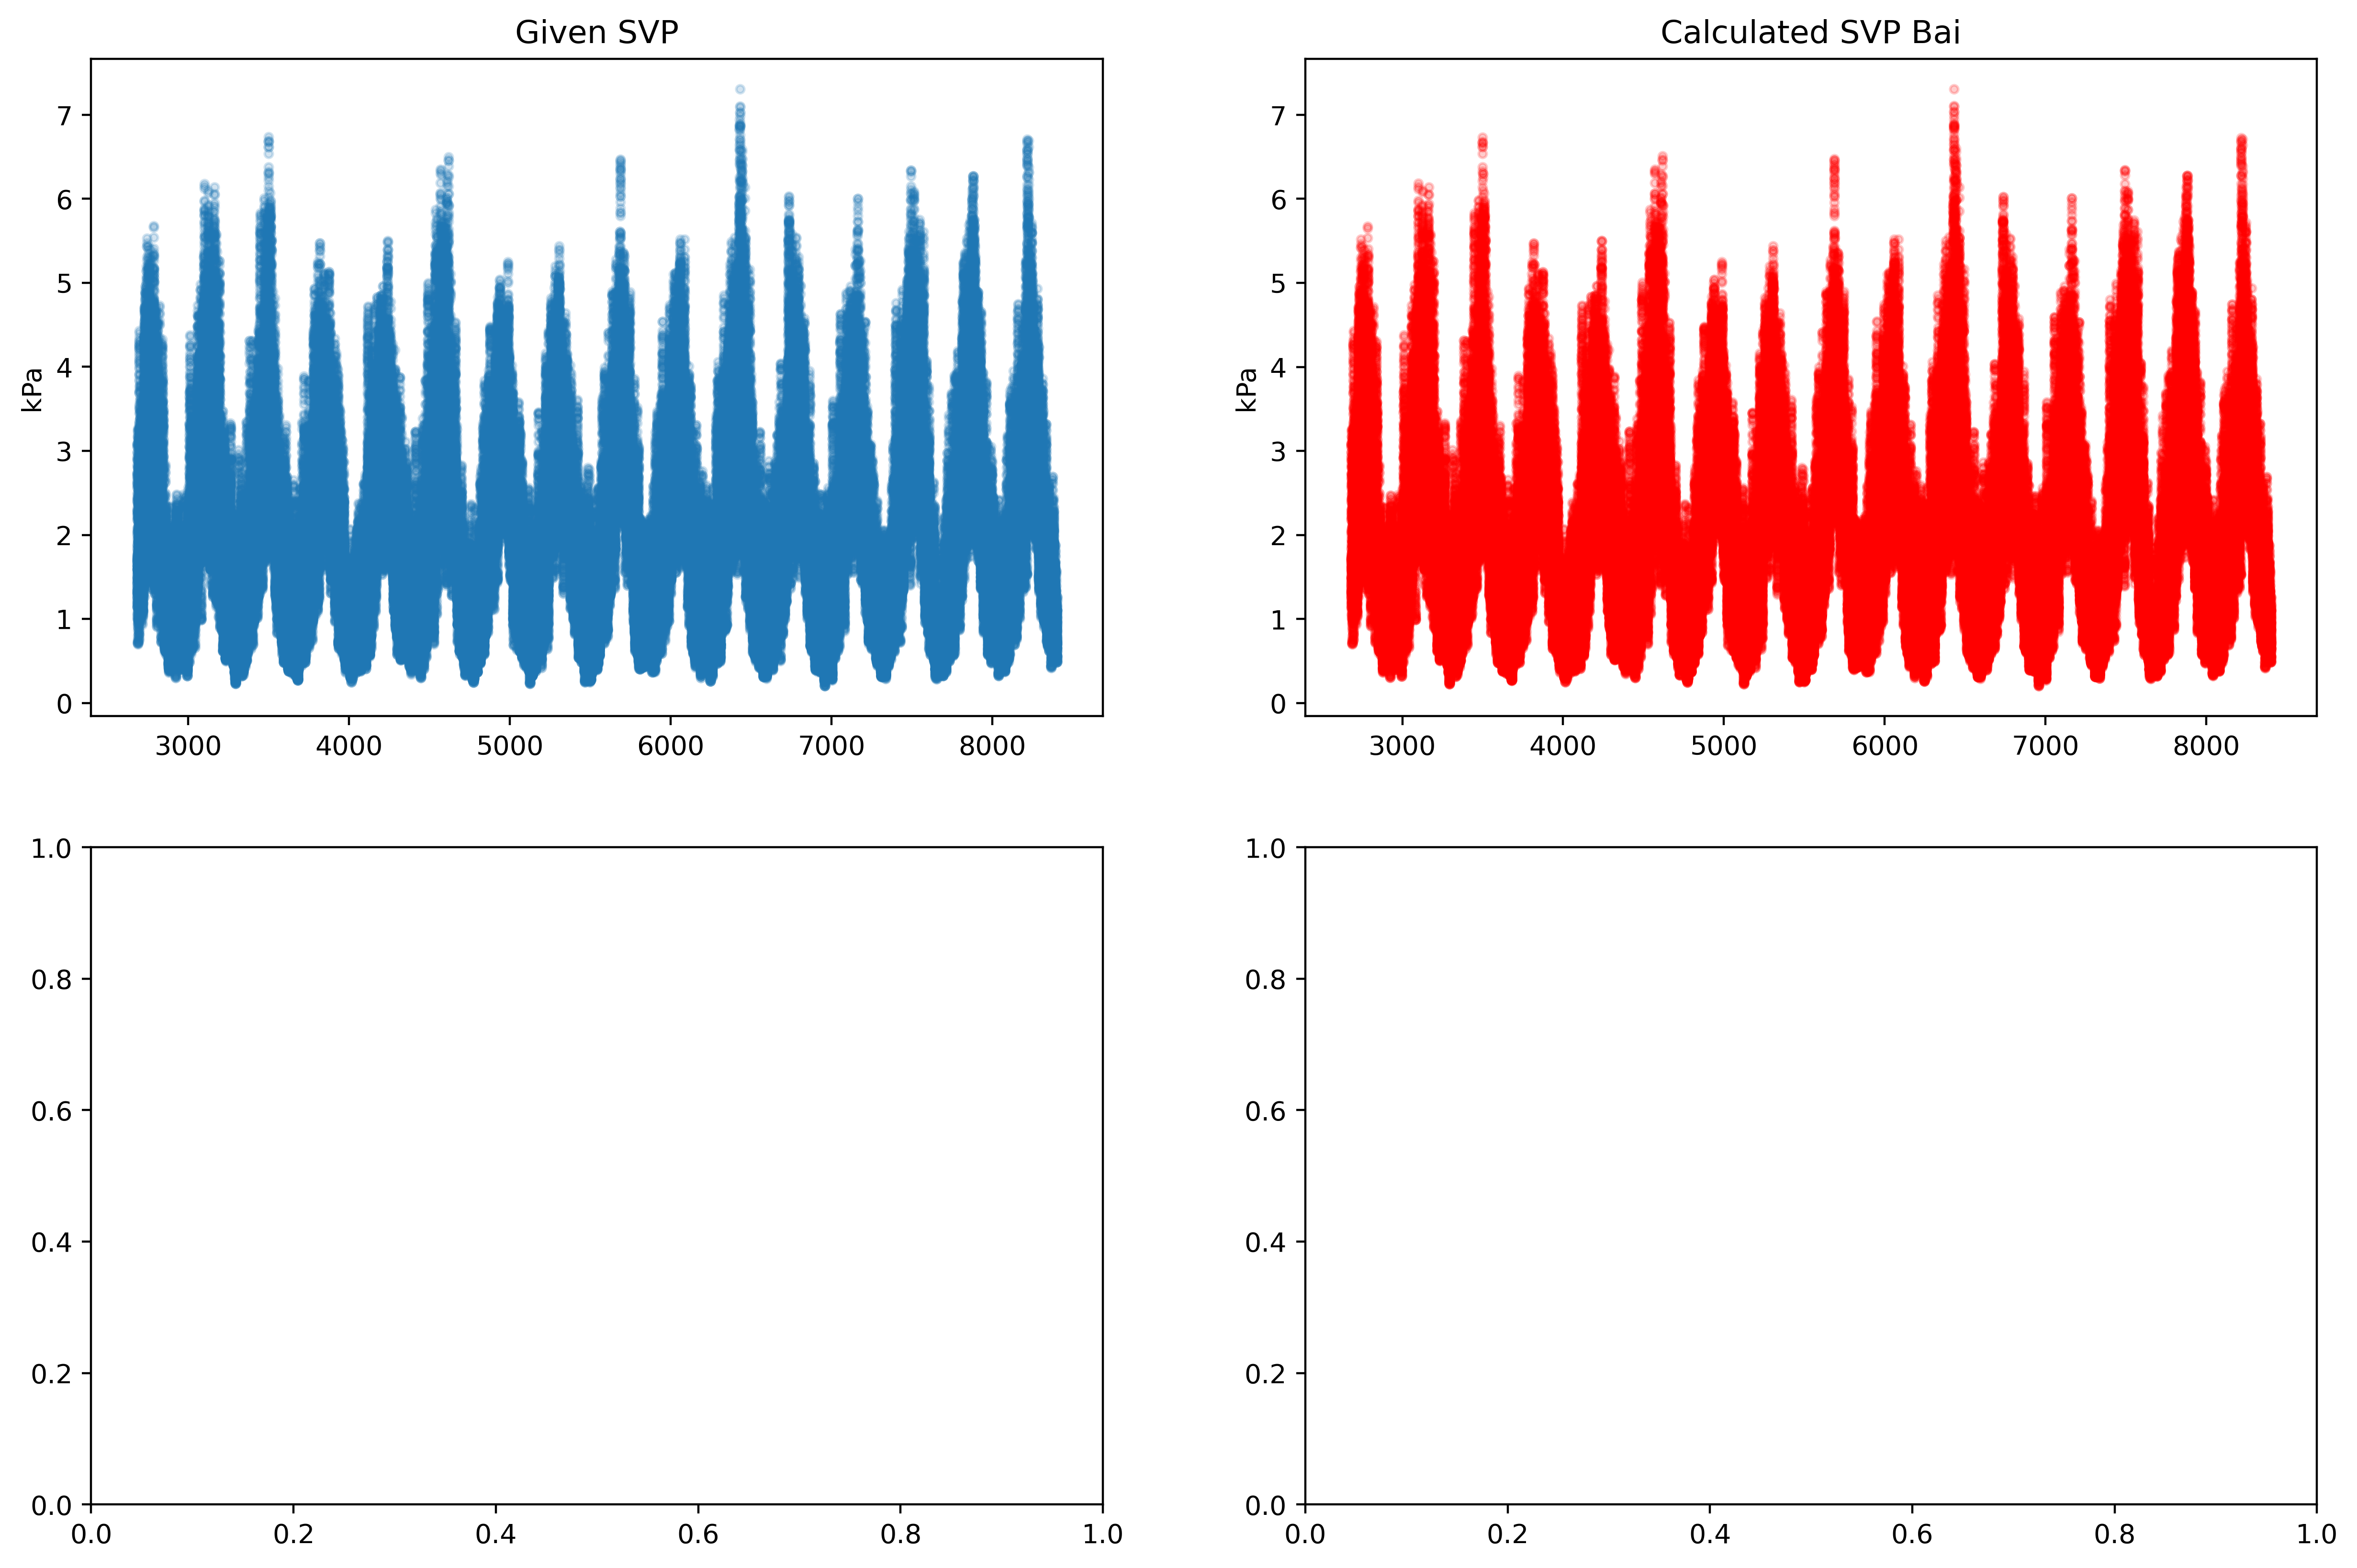

In [51]:


fig, axs = plt.subplots(2,2 , figsize=(15,10), dpi=400)


# 1
idx_ax = (0,0)
#var_plot = "Rainf"
#factor_add = 0
#factor_multiple = 1 # 1/(60*30) # From per day to per second for 48 timesteps in a day i.e. 24*60*60/48
axs[idx_ax].scatter(dict_dfs_common['SVP']['JDT'], dict_dfs_common['SVP']['SVP'], marker=".", label = f"SVP",alpha=.2)
axs[idx_ax].set_ylabel (f"kPa")
#axs[idx_ax].set_ylim (0,.025)
axs[idx_ax].title.set_text("Given SVP")
#axs[idx_ax].grid(b=True, which='major', axis='both', linestyle='--', color='gray', linewidth=0.5)
idx_axr = (0,1)
axs[idx_axr].scatter(df_temp['JDT'], df_temp['SVP'], marker=".", color = 'r', label = f"Calc SVP", alpha=.2)
axs[idx_axr].set_ylabel (f"kPa")
#axs[idx_axr].grid(b=True, which='major', axis='both', linestyle='--', color='gray', linewidth=0.5)
axs[idx_axr].title.set_text("Calculated SVP Bai")
#axs[idx_axr].set_ylim (0,.025)
#plt.legend()

In [52]:
df_temp = dict_dfs_common['Tair'].copy(deep=True)

# Apply the sat_vap function to create a new column 'Sat_Vap' in the DataFrame
#df_temp['SVP'] = df_temp['Tair'].apply(lambda x: sat_vap(x))
df_temp['VPD'] = dict_dfs_common["VPD"]["VPD"]
# Apply the lw_3 function to create a new column 'LWDown' in the DataFrame
df_temp['LWDown'] = df_temp.apply(lambda row: LWDown_oneflux(row['Tair'], row['VPD']), axis=1)
df_temp

Year      JDT  DOY  Time   Tair   VPD      LWDown
0      1997  2682.71  125  1730  21.50  1.47  369.459178
1      1997  2682.73  125  1800  20.41  1.22  361.096455
2      1997  2682.75  125  1830  18.89  0.96  349.556857
3      1997  2682.77  125  1900  17.91  0.99  341.820331
4      1997  2682.79  125  1930  16.61  0.90  332.075109
...     ...      ...  ...   ...    ...   ...         ...
17563  2012  8401.90  366  2200   7.58  0.56  269.683969
17564  2012  8401.92  366  2230   7.08  0.52  266.612588
17565  2012  8401.94  366  2300   6.88  0.50  265.409721
17566  2012  8401.96  366  2330   7.17  0.52  267.191471
17567  2012  8401.98  366  2400   7.44  0.54  268.855050

[274526 rows x 7 columns]

In [53]:
# Function to convert JDT to datetime
from datetime import datetime, timedelta
def jdt_to_datetime(jdt):
    # Julian Date and Time to datetime
    days = int(jdt)
    seconds = (jdt - days) * 86400  # Convert fractional day to seconds
    delta = timedelta(days=days, seconds=seconds)
    reference_date = datetime(1989, 12, 31)  # Julian Date reference date
    return reference_date + delta

# Apply the jdt_to_datetime function to create a new column 'Datetime'
df_temp['Datetime'] = df_temp['JDT'].apply(jdt_to_datetime)
df_temp['Datetime']

0       1997-05-05 17:02:24
1       1997-05-05 17:31:12
2       1997-05-05 18:00:00
3       1997-05-05 18:28:48
4       1997-05-05 18:57:36
                ...        
17563   2012-12-31 21:36:00
17564   2012-12-31 22:04:48
17565   2012-12-31 22:33:36
17566   2012-12-31 23:02:24
17567   2012-12-31 23:31:12
Name: Datetime, Length: 274526, dtype: datetime64[ns]

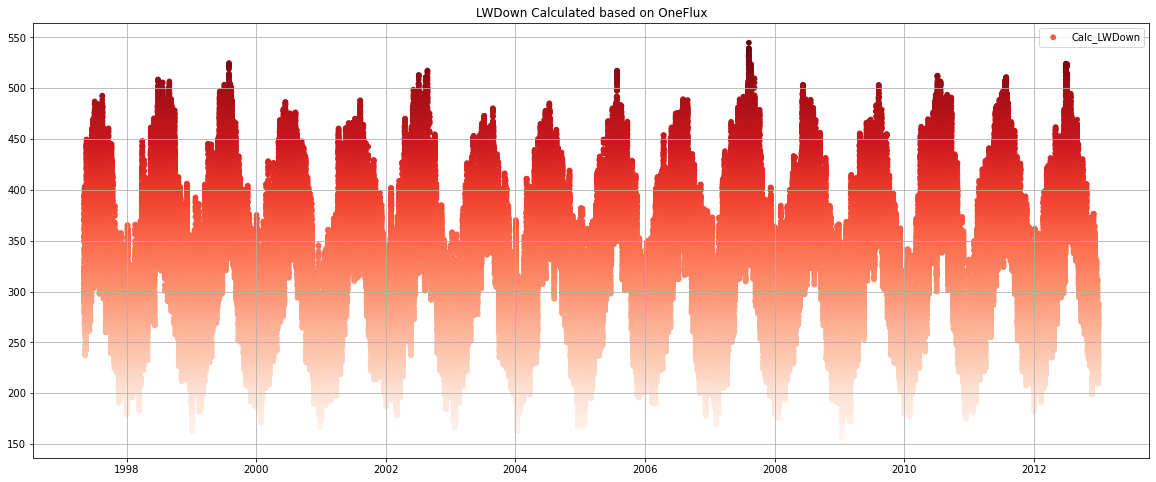

In [54]:
fig2 = plt.figure(figsize=(20,8))
plt.scatter(x= df_temp['Datetime'], y=df_temp['LWDown'], 
            c=df_temp['LWDown'], cmap='Reds', 
            s=22, marker = 'o',label = 'Calc_LWDown'#ds_Walker_h['LWdown'].units
           )
plt.title(f"LWDown Calculated based on OneFlux")
plt.legend()
plt.grid()

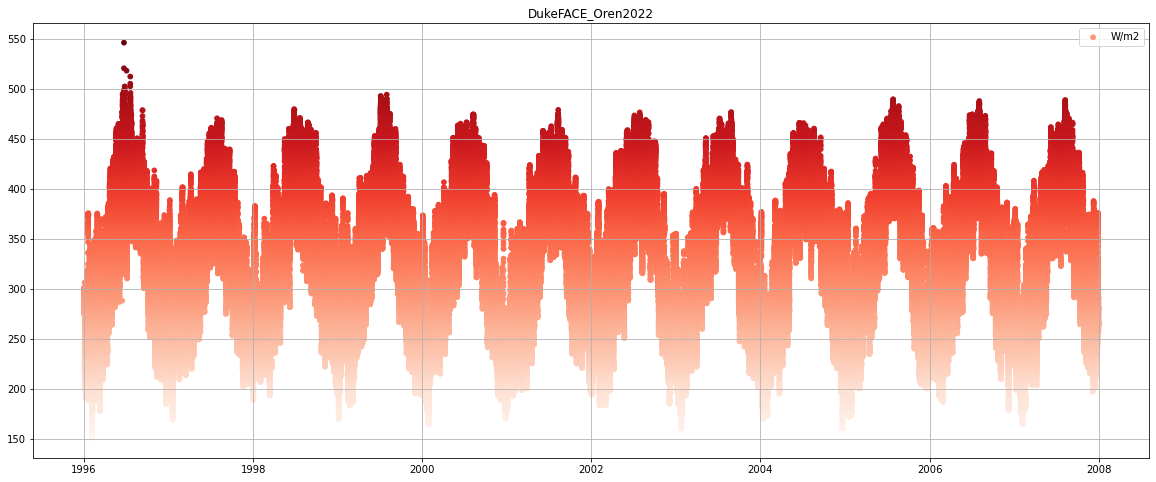

In [55]:
fig2 = plt.figure(figsize=(20,8))
plt.scatter(x= resulting_datetime, y=ds_Walker_h['LWdown'], 
            c=ds_Walker_h['LWdown'], cmap='Reds', 
            s=22, marker = 'o',label = ds_Walker_h['LWdown'].units
           )
plt.title(f"{key}")
plt.legend()
plt.grid()

### Pressure and Wind
Source: https://www.ncei.noaa.gov/access/search/data-search/local-climatological-data?dataTypes=HourlySeaLevelPressure&dataTypes=HourlyStationPressure&dataTypes=HourlyWindDirection&dataTypes=HourlyWindSpeed&pageNum=2&startDate=1996-01-01T00:00:00&endDate=2013-01-01T23:59:59&bbox=36.133,-79.020,35.828,-78.714 <br>
`RALEIGH_AIRPORT_Wind_Pressure.csv` <br>


In [151]:
df = pd.read_csv(paths ["Raleigh_Airport_Met"] + 'RALEIGH_AIRPORT_Wind_Pressure.csv')
df

/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


STATION                 DATE REPORT_TYPE SOURCE  \
0       72306013722  1996-01-01T00:00:00       SAO        3   
1       72306013722  1996-01-01T01:00:00       SY-SA      3   
2       72306013722  1996-01-01T02:00:00       SAO        3   
3       72306013722  1996-01-01T02:28:00       SAOSP      4   
4       72306013722  1996-01-01T03:00:00       SAO        3   
...             ...                  ...         ...    ...   
254834  72306013722  2013-01-01T21:51:00       FM-15      7   
254835  72306013722  2013-01-01T22:49:00       FM-16      6   
254836  72306013722  2013-01-01T22:51:00       FM-15      7   
254837  72306013722  2013-01-01T23:51:00       FM-15      7   
254838  72306013722  2013-01-01T23:59:00       SOD        6   

        HourlySeaLevelPressure  HourlyStationPressure HourlyWindDirection  \
0                        29.84                  29.36                 120   
1                        29.83                  29.36                 000   
2                        29.82                  29.35                 000   
3                          NaN                  29.35                 140   
4                        29.82                  29.34                 000   
...                        ...                    ...                 ...   
254834                   29.99                  29.52                 000   
254835                     NaN                  29.51                 000   
254836                   29.97                  29.50                 000   
254837                   29.97                  29.50                 000   
254838                     NaN                    NaN                 NaN   

        HourlyWindSpeed  
0                   3.0  
1                   0.0  
2                   0.0  
3                   3.0  
4                   0.0  
...                 ...  
254834              0.0  
254835              0.0  
254836              0.0  
254837              0.0  
254838              NaN  

[254839 rows x 8 columns]

In [152]:
def inch_mercury_to_pascal(inch_mercury):
    """
    Convert inches of mercury (inHg) to pascals (Pa).

    :param inch_mercury: Value in inches of mercury
    :return: Value in pascals
    """
    # Conversion factor: 1 inHg = 3386.39 Pa
    pascal = inch_mercury * 3386.39
    return pascal


In [153]:
# Converting the units of pressure from inchHG to Pa
df['Psurf_SL'] = df['HourlySeaLevelPressure'].apply(lambda x: inch_mercury_to_pascal(x))
df['Psurf_St'] = df['HourlyStationPressure'].apply(lambda x: inch_mercury_to_pascal(x))
df['Datetime'] = pd.to_datetime(df['DATE'])

# Subsetting the DataFrame that we need
df_PW = df[['Datetime', 'Psurf_SL','HourlyWindSpeed']]
df_PW['Wind'] = df_PW['HourlyWindSpeed']
df_PW = df_PW.drop('HourlyWindSpeed', axis=1)

# Resampling the dataframe to 30 mins timestep
# Convert 'Datetime' column to datetime type and set it as the index
df_PW['Datetime'] = pd.to_datetime(df_PW['Datetime'])
df_PW.set_index('Datetime', inplace=True)

# Remove duplicate index values
df_PW = df_PW[~df_PW.index.duplicated(keep='first')]

# Resample to 30-minute intervals and fill missing/Nan values with forward-fill
df_PW_resampled = df_PW.resample('30T').ffill()

# Interpolate NaN values using linear interpolation
df_PW_resampled.interpolate(method='linear', inplace=True)

# Replacing very high values (1000 m/s) of Wind with 0
df_PW_resampled['Wind'][df_PW_resampled['Wind'] > 1000] = 0

# Reset the index to have 'Datetime' as a regular column
df_PW_resampled_dtcol = df_PW_resampled.reset_index()


# Display the resampled DataFrame
df_PW_resampled



/var/folders/f1/01gxw8vn74q_x_rf_p5ztryjr405zq/T/ipykernel_96395/669406803.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PW['Wind'] = df_PW['HourlyWindSpeed']


Psurf_SL  Wind
Datetime                              
1996-01-01 00:00:00  101049.8776   3.0
1996-01-01 00:30:00  101049.8776   3.0
1996-01-01 01:00:00  101016.0137   0.0
1996-01-01 01:30:00  101016.0137   0.0
1996-01-01 02:00:00  100982.1498   0.0
...                          ...   ...
2013-01-01 21:30:00  101557.8361   0.0
2013-01-01 22:00:00  101557.8361   0.0
2013-01-01 22:30:00  101557.8361   0.0
2013-01-01 23:00:00  101490.1083   0.0
2013-01-01 23:30:00  101490.1083   0.0

[298128 rows x 2 columns]

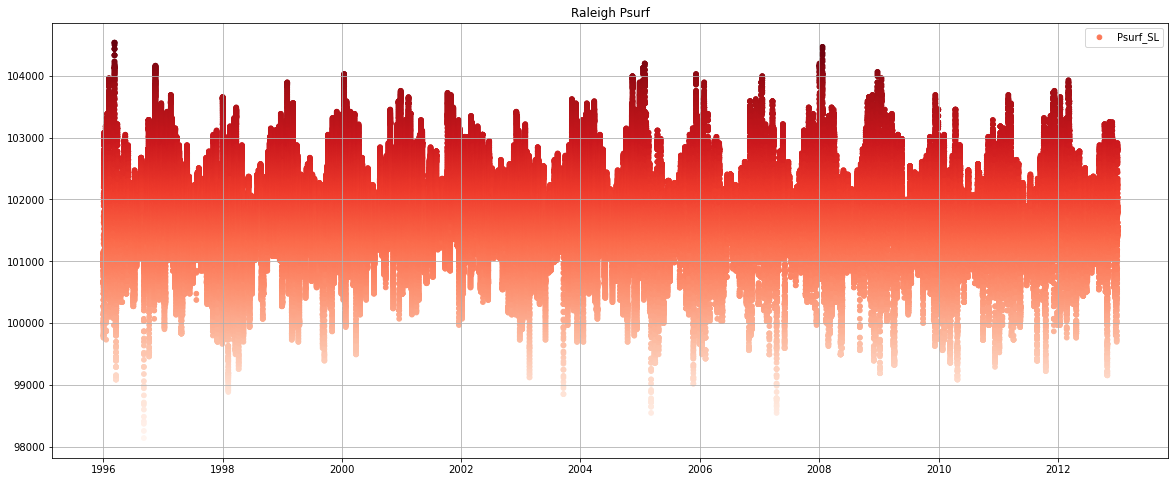

In [154]:
fig2 = plt.figure(figsize=(20,8))
plt.scatter(x= df_PW_resampled_dtcol['Datetime'], y=df_PW_resampled['Psurf_SL'], 
            c=df_PW_resampled['Psurf_SL'], cmap='Reds', 
            s=22, marker = 'o',label = 'Psurf_SL'#ds_Walker_h['LWdown'].units
           )
plt.title(f"Raleigh Psurf")
plt.legend()
plt.grid()

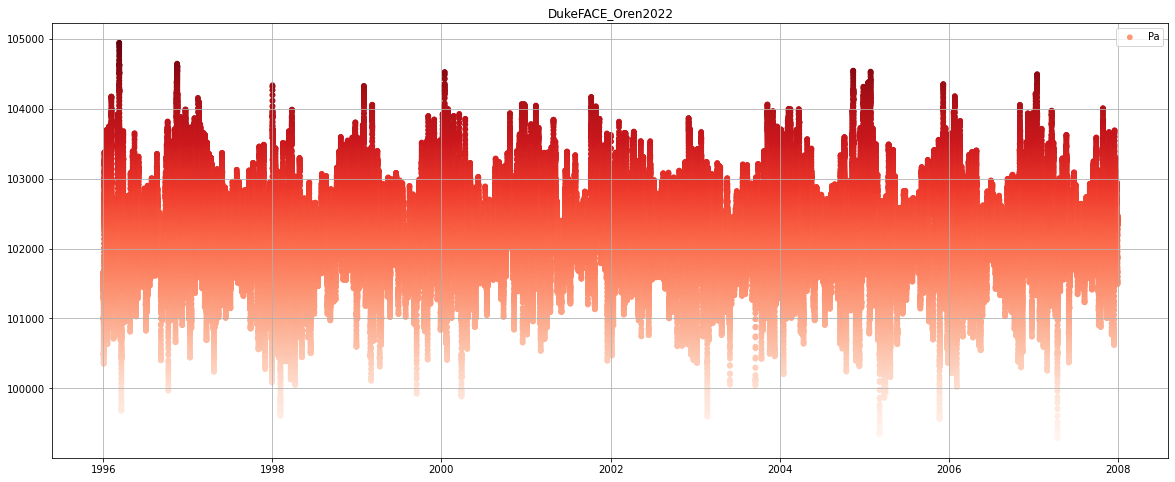

In [155]:
fig2 = plt.figure(figsize=(20,8))
plt.scatter(x= resulting_datetime, y=ds_Walker_h['Psurf'], 
            c=ds_Walker_h['Psurf'], cmap='Reds', 
            s=22, marker = 'o',label = ds_Walker_h['Psurf'].units
           )
plt.title(f"{key}")
plt.legend()
plt.grid()

In [156]:
df_Psurf_Walker = pd.DataFrame(ds_Walker_h['Psurf'].values[:,0,0], index=resulting_datetime)
df_Psurf_Walker.columns = ['Psurf']
df_Psurf_Walker
df_Psurf_Walkers = df_Psurf_Walker.resample('30T').mean()
df_Psurf_Walkers

Psurf
1996-01-01 00:00:00  101333.070312
1996-01-01 00:30:00  101315.164062
1996-01-01 01:00:00  101430.000000
1996-01-01 01:30:00  101446.617188
1996-01-01 02:00:00  101462.960938
...                            ...
2007-12-31 21:30:00  102394.960938
2007-12-31 22:00:00  101508.695312
2007-12-31 22:30:00  101543.773438
2007-12-31 23:00:00  101597.718750
2007-12-31 23:30:00  101662.437500

[210384 rows x 1 columns]

In [157]:
df_Wind_Walker = pd.DataFrame(ds_Walker_h['Wind'].values[:,0,0], index=resulting_datetime)
df_Wind_Walker.columns = ['Walker_Wind']
df_Wind_Walker
df_Wind_Walkers = df_Wind_Walker.resample('30T').mean()
df_Wind_Walkers

Walker_Wind
1996-01-01 00:00:00        1.560
1996-01-01 00:30:00        0.780
1996-01-01 01:00:00        0.000
1996-01-01 01:30:00        0.000
1996-01-01 02:00:00        0.000
...                          ...
2007-12-31 21:30:00        0.695
2007-12-31 22:00:00        0.664
2007-12-31 22:30:00        0.801
2007-12-31 23:00:00        0.881
2007-12-31 23:30:00        0.881

[210384 rows x 1 columns]

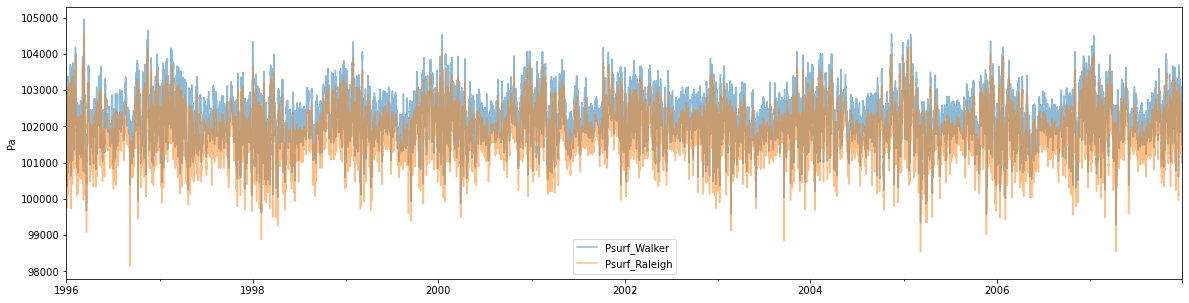

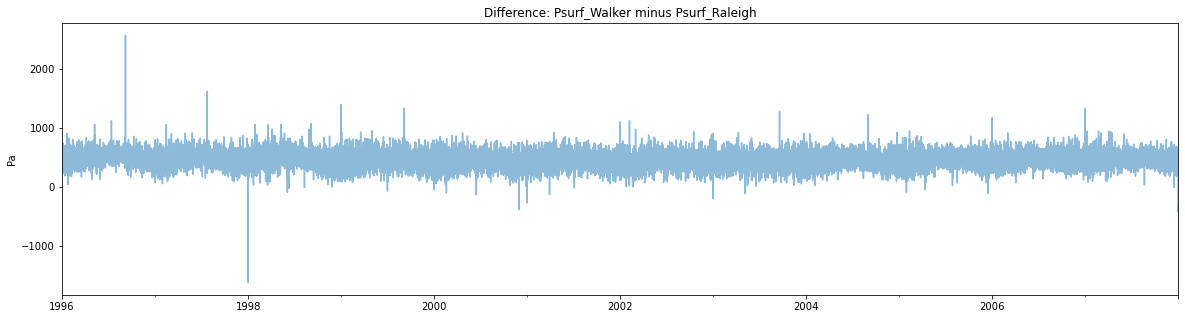

The pressure at the site is 464.0398280150264 Pa higher than Releigh Airport (av 1996-2008)


In [163]:
#df_Psurf_Walkers.merge?
df_Psurf_comp = df_Psurf_Walkers.join(df_PW_resampled['Psurf_SL'])
df_Psurf_comp.columns = ['Psurf_Walker', 'Psurf_Raleigh']
df_Psurf_comp ['Ori-New'] = df_Psurf_comp['Psurf_Walker'] - df_Psurf_comp['Psurf_Raleigh']
df_Psurf_comp[['Psurf_Walker', 'Psurf_Raleigh']].plot(alpha=.5, figsize=(20,5))
plt.ylabel("Pa")
plt.show()

df_Psurf_comp['Ori-New'].plot(alpha=.5, figsize=(20,5))
plt.title('Difference: Psurf_Walker minus Psurf_Raleigh')
plt.ylabel("Pa")
plt.show()
print(f"The pressure at the site is {df_Psurf_comp['Ori-New'].mean()} Pa higher than Releigh Airport (av 1996-2008)")


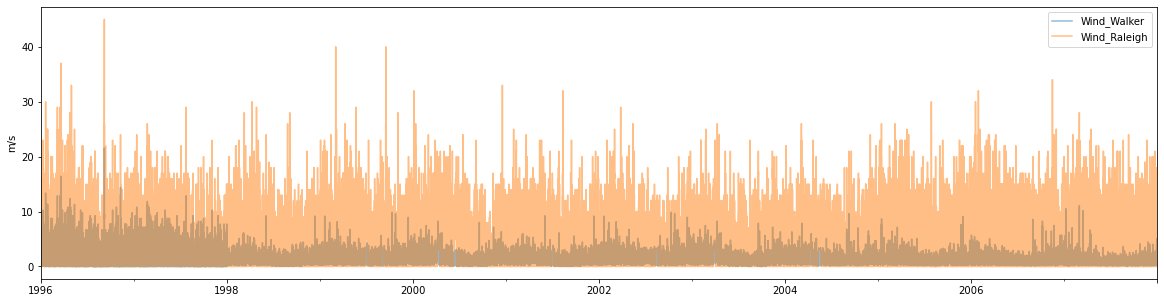

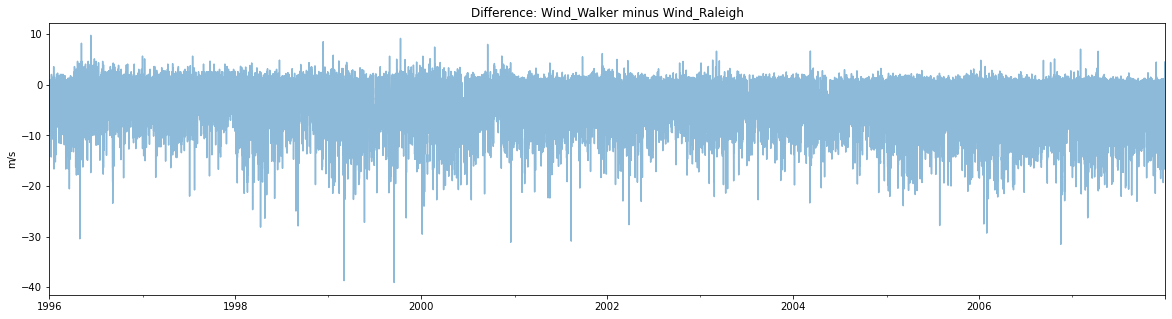

The wind at the site is -4.304747187623177 m/s higher than Releigh Airport (av 1996-2008)


In [164]:
#df_Psurf_Walkers.merge?
df_Wind_comp = df_Wind_Walkers.join(df_PW_resampled['Wind'])
df_Wind_comp.columns = ['Wind_Walker', 'Wind_Raleigh']
df_Wind_comp ['Ori-New'] = df_Wind_comp['Wind_Walker'] - df_Wind_comp['Wind_Raleigh']
df_Wind_comp[['Wind_Walker', 'Wind_Raleigh']].plot(alpha=.5, figsize=(20,5))
plt.ylabel("m/s")
plt.show()
df_Wind_comp['Ori-New'].plot(alpha=.5, figsize=(20,5))
plt.title('Difference: Wind_Walker minus Wind_Raleigh')
plt.ylabel("m/s")
plt.show()
print(f"The wind at the site is {df_Wind_comp['Ori-New'].mean()} m/s higher than Releigh Airport (av 1996-2008)")

# Note:

We might have to do some mapping of wind and pressure from the common timeseries to the unknown time series.

In [160]:
df_Wind_Walkers

Walker_Wind
1996-01-01 00:00:00        1.560
1996-01-01 00:30:00        0.780
1996-01-01 01:00:00        0.000
1996-01-01 01:30:00        0.000
1996-01-01 02:00:00        0.000
...                          ...
2007-12-31 21:30:00        0.695
2007-12-31 22:00:00        0.664
2007-12-31 22:30:00        0.801
2007-12-31 23:00:00        0.881
2007-12-31 23:30:00        0.881

[210384 rows x 1 columns]

In [80]:
df_Psurf_Walkers.head(10)

Psurf
1996-01-01 00:00:00  101333.070312
1996-01-01 00:30:00  101315.164062
1996-01-01 01:00:00  101430.000000
1996-01-01 01:30:00  101446.617188
1996-01-01 02:00:00  101462.960938
1996-01-01 02:30:00  101478.742188
1996-01-01 03:00:00  101493.695312
1996-01-01 03:30:00  101507.539062
1996-01-01 04:00:00  101520.000000
1996-01-01 04:30:00  101530.984375

In [64]:
df_PW_resampled.head(10)

Datetime     Psurf_SL  Wind
0 1996-01-01 00:00:00  101049.8776   3.0
1 1996-01-01 00:30:00  101049.8776   3.0
2 1996-01-01 01:00:00  101016.0137   0.0
3 1996-01-01 01:30:00  101016.0137   0.0
4 1996-01-01 02:00:00  100982.1498   0.0
5 1996-01-01 02:30:00  100982.1498   3.0
6 1996-01-01 03:00:00  100982.1498   0.0
7 1996-01-01 03:30:00  100982.1498   0.0
8 1996-01-01 04:00:00  100914.4220   3.0
9 1996-01-01 04:30:00  100914.4220   4.0

In [65]:
df_PW_resampled

Datetime     Psurf_SL  Wind
0      1996-01-01 00:00:00  101049.8776   3.0
1      1996-01-01 00:30:00  101049.8776   3.0
2      1996-01-01 01:00:00  101016.0137   0.0
3      1996-01-01 01:30:00  101016.0137   0.0
4      1996-01-01 02:00:00  100982.1498   0.0
...                    ...          ...   ...
298123 2013-01-01 21:30:00  101557.8361   0.0
298124 2013-01-01 22:00:00  101557.8361   0.0
298125 2013-01-01 22:30:00  101557.8361   0.0
298126 2013-01-01 23:00:00  101490.1083   0.0
298127 2013-01-01 23:30:00  101490.1083   0.0

[298128 rows x 3 columns]

In [66]:
from datetime import datetime

date_string = "1996-01-01T00:00:00"
datetime_object = datetime.fromisoformat(date_string)

print(datetime_object)


1996-01-01 00:00:00


In [67]:
pd.to_datetime(df['DATE'])

0        1996-01-01 00:00:00
1        1996-01-01 01:00:00
2        1996-01-01 02:00:00
3        1996-01-01 02:28:00
4        1996-01-01 03:00:00
                 ...        
254834   2013-01-01 21:51:00
254835   2013-01-01 22:49:00
254836   2013-01-01 22:51:00
254837   2013-01-01 23:51:00
254838   2013-01-01 23:59:00
Name: DATE, Length: 254839, dtype: datetime64[ns]

In [68]:
ds_Walker_h.Psurf[0:10]

<xarray.DataArray 'Psurf' (tstep: 10, y: 1, x: 1)>
array([[[101333.07 ]],

       [[101315.164]],

       [[101430.   ]],

       [[101446.62 ]],

       [[101462.96 ]],

       [[101478.74 ]],

       [[101493.695]],

       [[101507.54 ]],

       [[101520.   ]],

       [[101530.984]]], dtype=float32)
Dimensions without coordinates: tstep, y, x
Attributes:
    units:      Pa
    long_name:  Surface barometric pressure
    associate:  time nav_lat nav_lon
    axis:       TYX

In [69]:
import pandas as pd

# Sample data
data = {
    'Datetime': [
        '1996-01-01 00:00:00',
        '1996-01-01 01:00:00',
        '1996-01-01 02:00:00',
        '1996-01-01 02:28:00',
        '1996-01-01 03:00:00',
        # Add more datetime values as needed
    ],
    'Psurf_SL': [
        101049.8776,
        101016.0137,
        100982.1498,
        None,  # Representing a missing/Nan value
        100982.1498,
        # Add more pressure values as needed
    ],
    'Wind': [
        3.0,
        0.0,
        0.0,
        3.0,
        0.0,
        # Add more wind values as needed
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert 'Datetime' column to datetime type and set it as the index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Resample to 30-minute intervals and fill missing/Nan values with forward-fill
df_resampled = df.resample('30T').ffill()
'''
# Reset the index to have 'Datetime' as a regular column
df_resampled.reset_index(inplace=True)

# Display the resampled DataFrame
print(df_resampled)
'''

"\n# Reset the index to have 'Datetime' as a regular column\ndf_resampled.reset_index(inplace=True)\n\n# Display the resampled DataFrame\nprint(df_resampled)\n"

In [70]:
df

Psurf_SL  Wind
Datetime                              
1996-01-01 00:00:00  101049.8776   3.0
1996-01-01 01:00:00  101016.0137   0.0
1996-01-01 02:00:00  100982.1498   0.0
1996-01-01 02:28:00          NaN   3.0
1996-01-01 03:00:00  100982.1498   0.0

In [71]:
df_resampled

Psurf_SL  Wind
Datetime                              
1996-01-01 00:00:00  101049.8776   3.0
1996-01-01 00:30:00  101049.8776   3.0
1996-01-01 01:00:00  101016.0137   0.0
1996-01-01 01:30:00  101016.0137   0.0
1996-01-01 02:00:00  100982.1498   0.0
1996-01-01 02:30:00          NaN   3.0
1996-01-01 03:00:00  100982.1498   0.0

In [72]:
ds_Walker_h.Wind[0:10]

/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.DataArray 'Wind' (tstep: 10, y: 1, x: 1)>
array([[[1.56]],

       [[0.78]],

       [[0.  ]],

       [[0.  ]],

       [[0.  ]],

       [[0.  ]],

       [[0.  ]],

       [[0.78]],

       [[1.56]],

       [[2.08]]], dtype=float32)
Dimensions without coordinates: tstep, y, x
Attributes:
    units:      m/s
    long_name:  Mean wind speed over a time step of measurement
    associate:  time nav_lat nav_lon
    axis:       TYX

In [73]:
dict_dfs_common.keys()

dict_keys(['Tair', 'Rainf', 'RH', 'SM', 'SWP', 'SVP', 'VPD', 'SLT', 'PAR', 'Rn', 'PAR_ori'])

### Making a common Dataframe of 30 min data

Largest timeseries is from "PAR" <br>
1997 - 2558.00 - 1 - 30 to 2012 - 8401.98 - 366 - 2400 <br>
Using these Index to fill in the rest <br>
FillValue = -6999.0

In [74]:
# list of variables 
keys_vars = list(dict_dfs_common.keys())

# Making a copy of the dataframe with most data
df_all_vars_30m =  dict_dfs_common['PAR'].copy(deep=True)

# Dropping JDT column since it is not same across vars based on Dates and time, due to which I get NaNs during merge
df_all_vars_30m = df_all_vars_30m.drop('JDT',axis=1)

for k in keys_vars:
    df_all_vars_30m = pd.merge(df_all_vars_30m, dict_dfs_common[k].drop('JDT',axis=1), how = 'left')
    
    
fill_value = -6999.    
df_all_vars_30m['Rn'] = df_all_vars_30m['Rn'].replace(fill_value, np.nan)

# Fill NaNs with -6999.0
df_all_vars_30m_FV = df_all_vars_30m.fillna(fill_value)

# Adding a datetime column 
# Convert DOY and Time to timedelta

# Convert 'Time' values to HH:MM format
time_str = df_all_vars_30m['Time'].astype(str)
time_str = time_str.str.zfill(4)  # Ensure all times are 4 digits

# Making Sure time_str in has integer values only
#time_int = time_str.astype(float).astype(int)
time_int = np.asarray(np.asarray(time_str, dtype=float), dtype =int)

# Extract hours and minutes
hours = np.asarray(time_int//100, dtype = int)
minutes = np.asarray(time_int%100, dtype = int)

# Calculate the total minutes
total_minutes = hours * 60 + minutes

df_all_vars_30m['Date'] = pd.to_timedelta(df_all_vars_30m['DOY'] - 1, unit='D') + pd.to_timedelta(total_minutes, unit='m')

# Add Year to the Date
df_all_vars_30m['Date'] = pd.to_datetime(df_all_vars_30m['Year'].astype(float).astype(int).astype(str)) + df_all_vars_30m['Date']
df_all_vars_30m_FV['Date'] = df_all_vars_30m['Date']



In [75]:
df_all_vars_30m_FV.head()

Year  DOY   Time  PAR  PAR_ori    Tair   Rainf      RH      SM     SWP  \
0  1997.0  1.0   30.0  0.0      0.0 -6999.0 -6999.0 -6999.0 -6999.0 -6999.0   
1  1997.0  1.0  100.0  0.0      0.0 -6999.0 -6999.0 -6999.0 -6999.0 -6999.0   
2  1997.0  1.0  130.0  0.0      0.0 -6999.0 -6999.0 -6999.0 -6999.0 -6999.0   
3  1997.0  1.0  200.0  0.0      0.0 -6999.0 -6999.0 -6999.0 -6999.0 -6999.0   
4  1997.0  1.0  230.0  0.0      0.0 -6999.0 -6999.0 -6999.0 -6999.0 -6999.0   

      SVP     VPD     SLT      Rn                Date  
0 -6999.0 -6999.0 -6999.0 -6999.0 1997-01-01 00:30:00  
1 -6999.0 -6999.0 -6999.0 -6999.0 1997-01-01 01:00:00  
2 -6999.0 -6999.0 -6999.0 -6999.0 1997-01-01 01:30:00  
3 -6999.0 -6999.0 -6999.0 -6999.0 1997-01-01 02:00:00  
4 -6999.0 -6999.0 -6999.0 -6999.0 1997-01-01 02:30:00

In [76]:

# Saving the processed Data

df_all_vars_30m_FV.to_csv(f"{paths['Save_Processed']}Processed_Duke_Met_Data_All_Vars_30m_FV.csv")
df_all_vars_30m.to_csv(f"{paths['Save_Processed']}Processed_Duke_Met_Data_All_Vars_30m.csv")

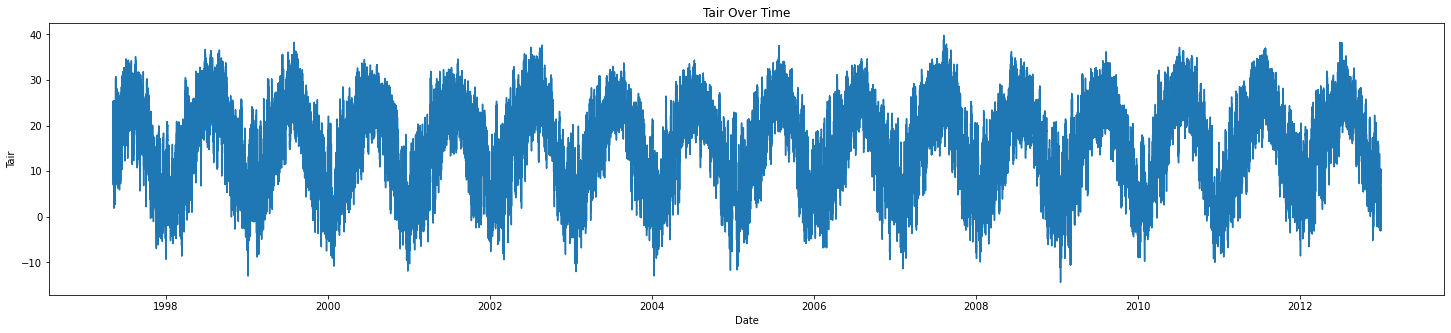

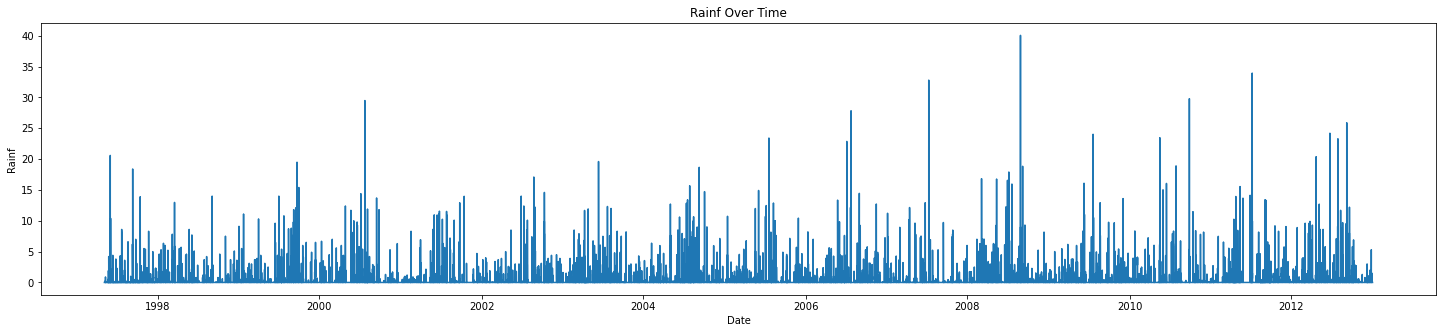

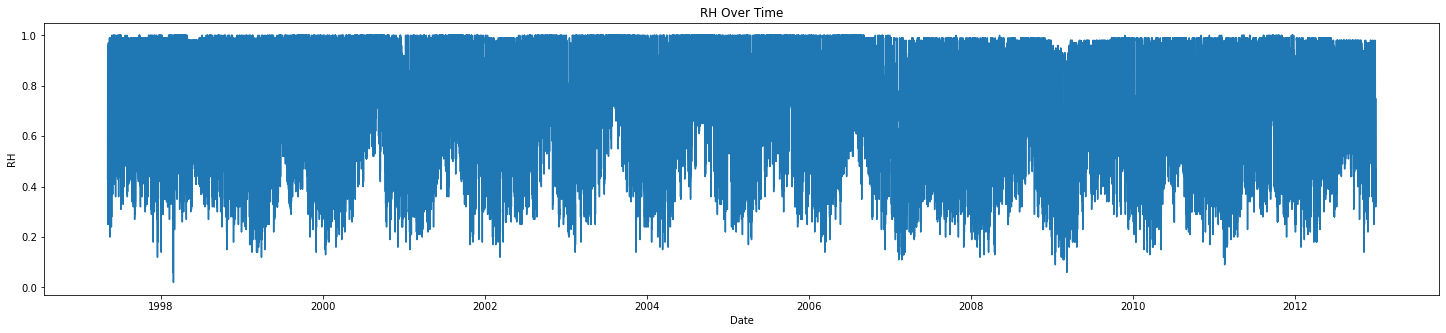

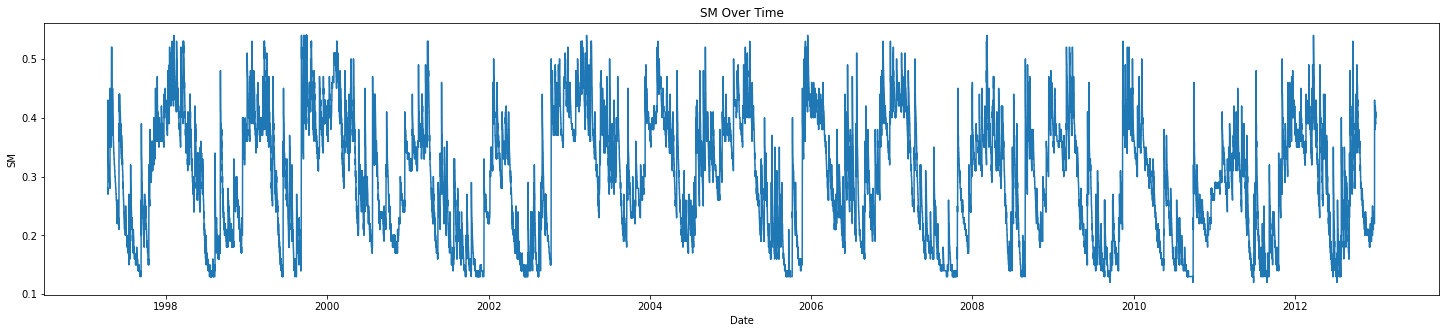

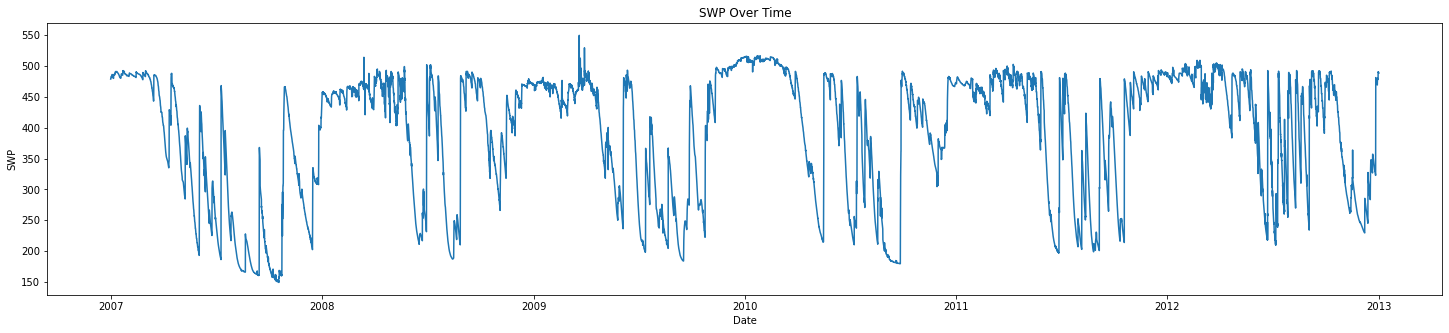

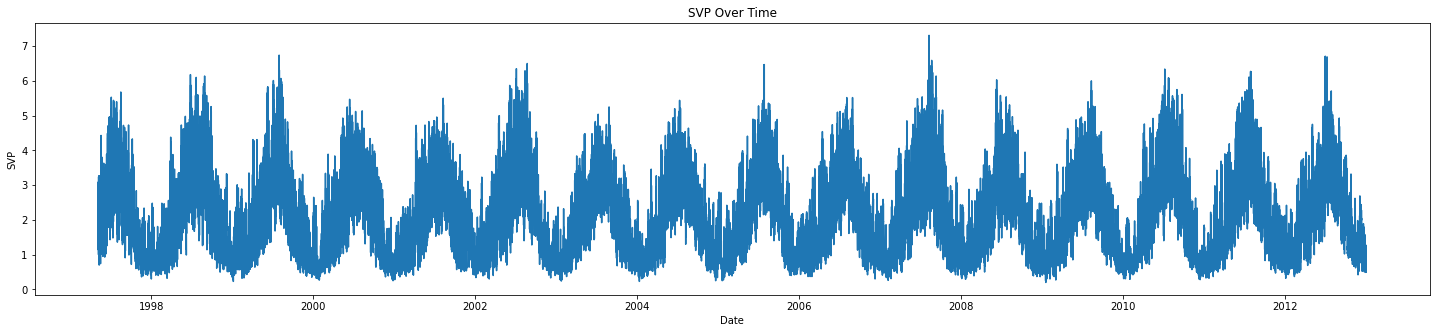

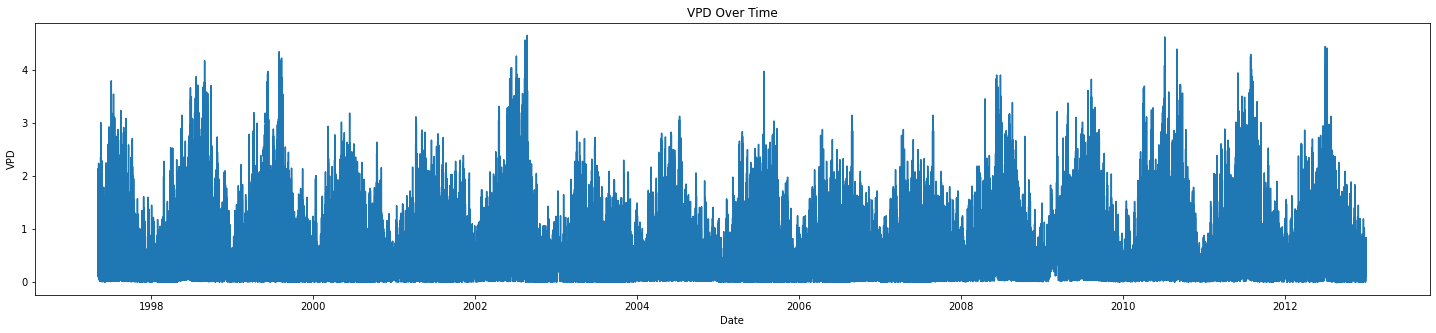

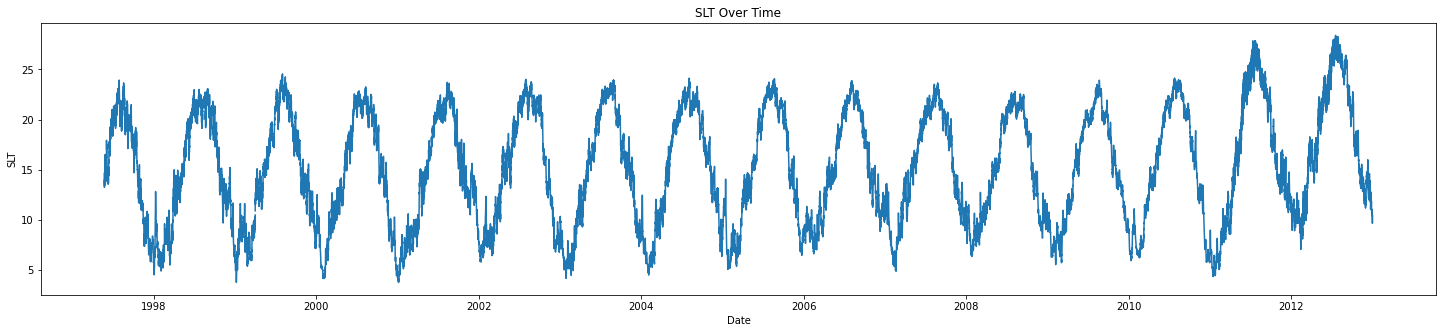

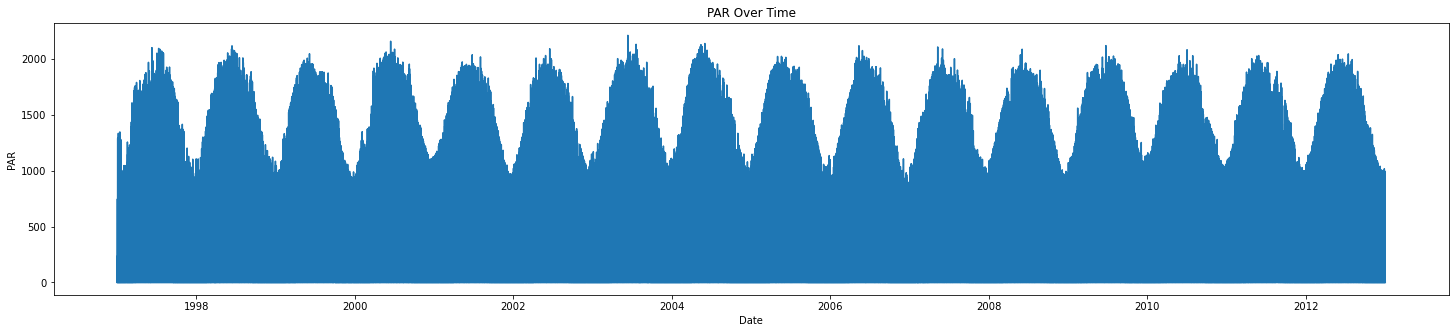

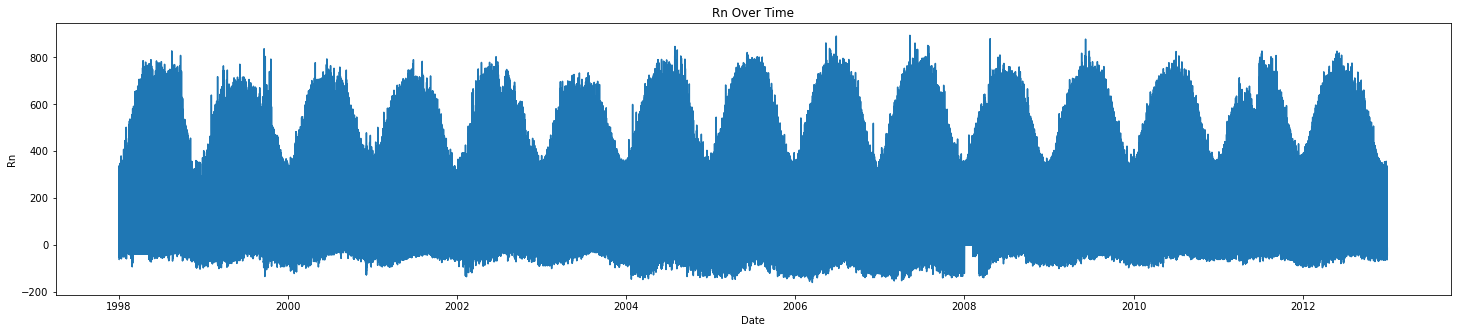

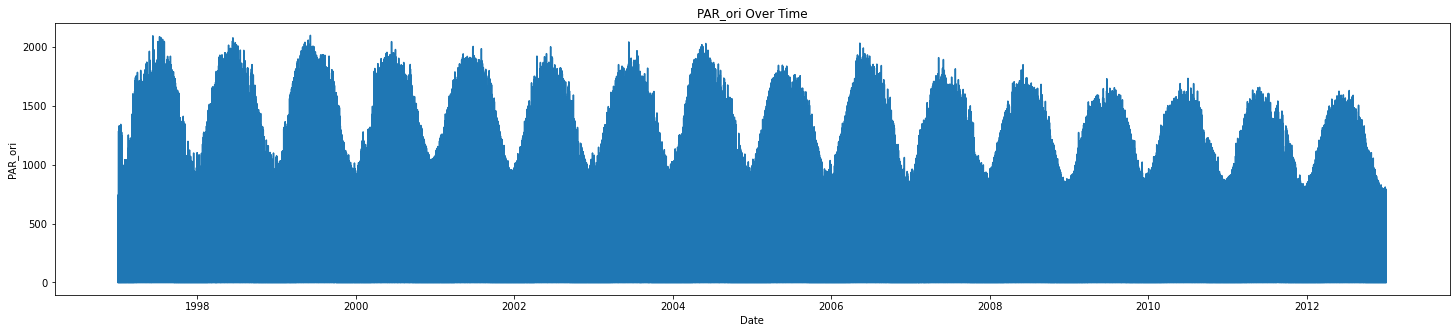

In [77]:
for k in keys_vars:
     # Set the figure size
    plt.figure(figsize=(25, 5))

    # Create the line plot
    plt.plot(df_all_vars_30m['Date'], df_all_vars_30m[k])

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel(k)
    plt.title(f'{k} Over Time')
